# Convert Raw Accelerometer Data to Minutely Step Counts (Forest Package)

This notebook uses the **official forest package** (cloned from GitHub) to compute step counts
from raw accelerometer data at minutely granularity.

This allows comparison with results from `05_convert_to_steps.ipynb` which uses the ported version.

## Forest Repository
- Source: https://github.com/onnela-lab/forest
- Location: `/n/home01/egraff/forest/`


In [5]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add forest source to path
FOREST_SRC = '/n/home01/egraff/forest/src'
if FOREST_SRC not in sys.path:
    sys.path.insert(0, FOREST_SRC)

# Import forest oak module
from forest.oak.base import run
from forest.constants import Frequency

print(f"Forest source: {FOREST_SRC}")
print(f"Frequency.MINUTE value: {Frequency.MINUTE.value}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Forest source: /n/home01/egraff/forest/src
Frequency.MINUTE value: 1


## Configure Paths and Participants


In [ ]:
# Configure paths
STUDY_FOLDER = '/n/home01/egraff/sample_imputation/data/raw'
OUTPUT_FOLDER = '/n/home01/egraff/sample_imputation/data/interim/forest_oak'
TZ_STR = 'America/New_York'

# Get participant IDs (excluding __MACOSX)
users = sorted([
    d.name for d in Path(STUDY_FOLDER).iterdir()
    if d.is_dir() and d.name != '__MACOSX'
])

print(f"Study folder: {STUDY_FOLDER}")
print(f"Output folder: {OUTPUT_FOLDER}")
print(f"Timezone: {TZ_STR}")
print(f"Found {len(users)} participants: {', '.join(users)}")


Study folder: /n/home01/egraff/sample_imputation/data/raw
Output folder: /n/home01/egraff/sample_imputation/data/interim/forest_oak
Timezone: America/New_York
Found 6 participants: 3si9xdvl, bn4j8yj9, gq36edfi, ubrmuu2r, xwyd72l9, zg5uqa5l


## Run Forest Oak with Minutely Frequency

This will process all accelerometer data and output step counts to:
`data/interim/forest_oak/minute/{user}_gait_hourly.csv`


In [ ]:
# Create output directory
Path(OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

# Run forest oak with minutely frequency
print("Running forest oak module...")
print("This may take several minutes depending on data size.\n")

run(
    study_folder=STUDY_FOLDER,
    output_folder=OUTPUT_FOLDER,
    tz_str=TZ_STR,
    frequency=Frequency.MINUTE,
    time_start=None,
    time_end=None,
    users=users
)

print("\nForest oak processing complete!")


Running forest oak module...
This may take several minutes depending on data size.



/n/home01/egraff/forest/src/forest/oak/base.py:676: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_hours_pd = t_series.dt.floor('T')
/n/home01/egraff/forest/src/forest/oak/base.py:676: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_hours_pd = t_series.dt.floor('T')
/n/home01/egraff/forest/src/forest/oak/base.py:676: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_hours_pd = t_series.dt.floor('T')
/n/home01/egraff/forest/src/forest/oak/base.py:676: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_hours_pd = t_series.dt.floor('T')
/n/home01/egraff/forest/src/forest/oak/base.py:676: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_hours_pd = t_series.dt.floor('T')
/n/home01/egraff/forest/src/forest/oak/base.py:676


Forest oak processing complete!


## Load Forest Oak Results


In [ ]:
# Load forest oak results
FOREST_OUTPUT_DIR = Path(OUTPUT_FOLDER) / 'minute'

forest_results: dict[str, pd.DataFrame] = {}

for user in users:
    # Forest outputs files as {user}_gait_hourly.csv even for minutely data
    forest_file = FOREST_OUTPUT_DIR / f'{user}_gait_hourly.csv'
    
    if forest_file.exists():
        df = pd.read_csv(forest_file)
        # Parse the date column
        df['timestamp'] = pd.to_datetime(df['date'])
        df = df.drop(columns=['date'])
        forest_results[user] = df
        print(f"Loaded forest results for {user}: {len(df):,} epochs")
    else:
        print(f"Warning: Forest output not found for {user}: {forest_file}")

print(f"\nLoaded forest results for {len(forest_results)} participants.")


Loaded forest results for 3si9xdvl: 11,520 epochs
Loaded forest results for bn4j8yj9: 11,520 epochs
Loaded forest results for gq36edfi: 11,520 epochs
Loaded forest results for ubrmuu2r: 11,520 epochs
Loaded forest results for xwyd72l9: 12,960 epochs
Loaded forest results for zg5uqa5l: 11,520 epochs

Loaded forest results for 6 participants.


## Plot Minutely Step Counts by Day

Plot step counts throughout each day for all participants (similar to MIMS plots).



Plotting 3si9xdvl...


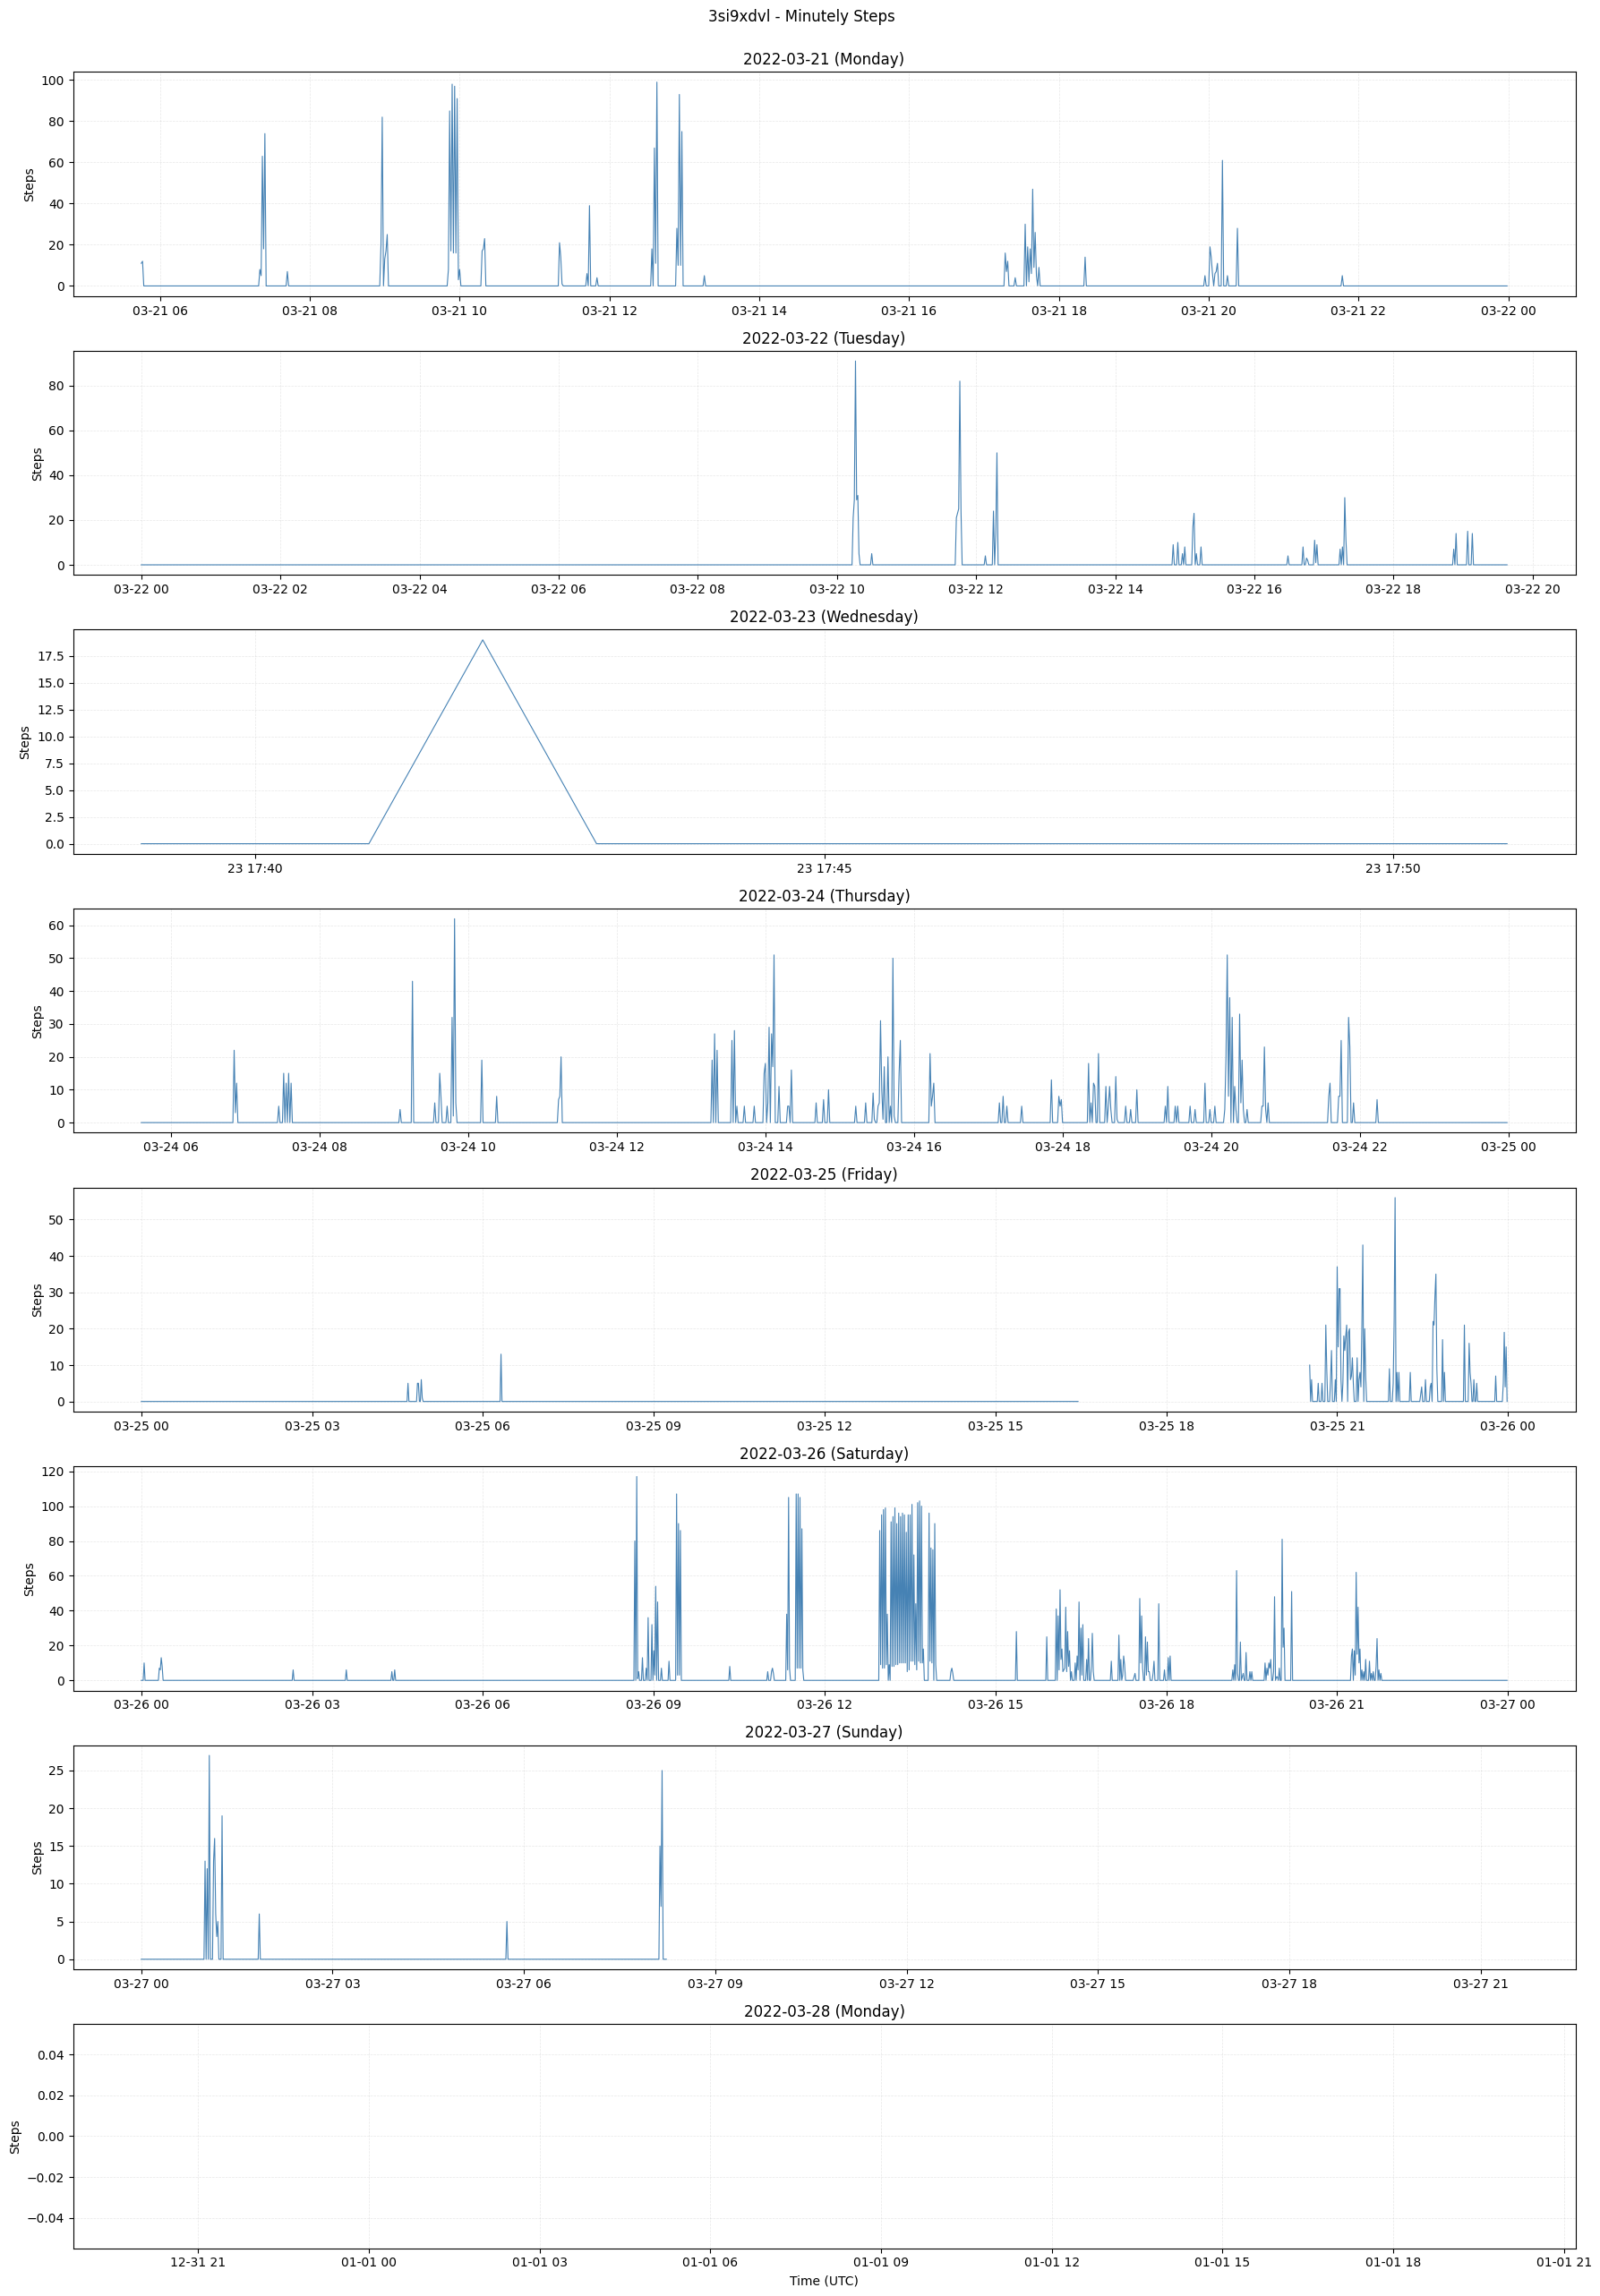


Plotting bn4j8yj9...


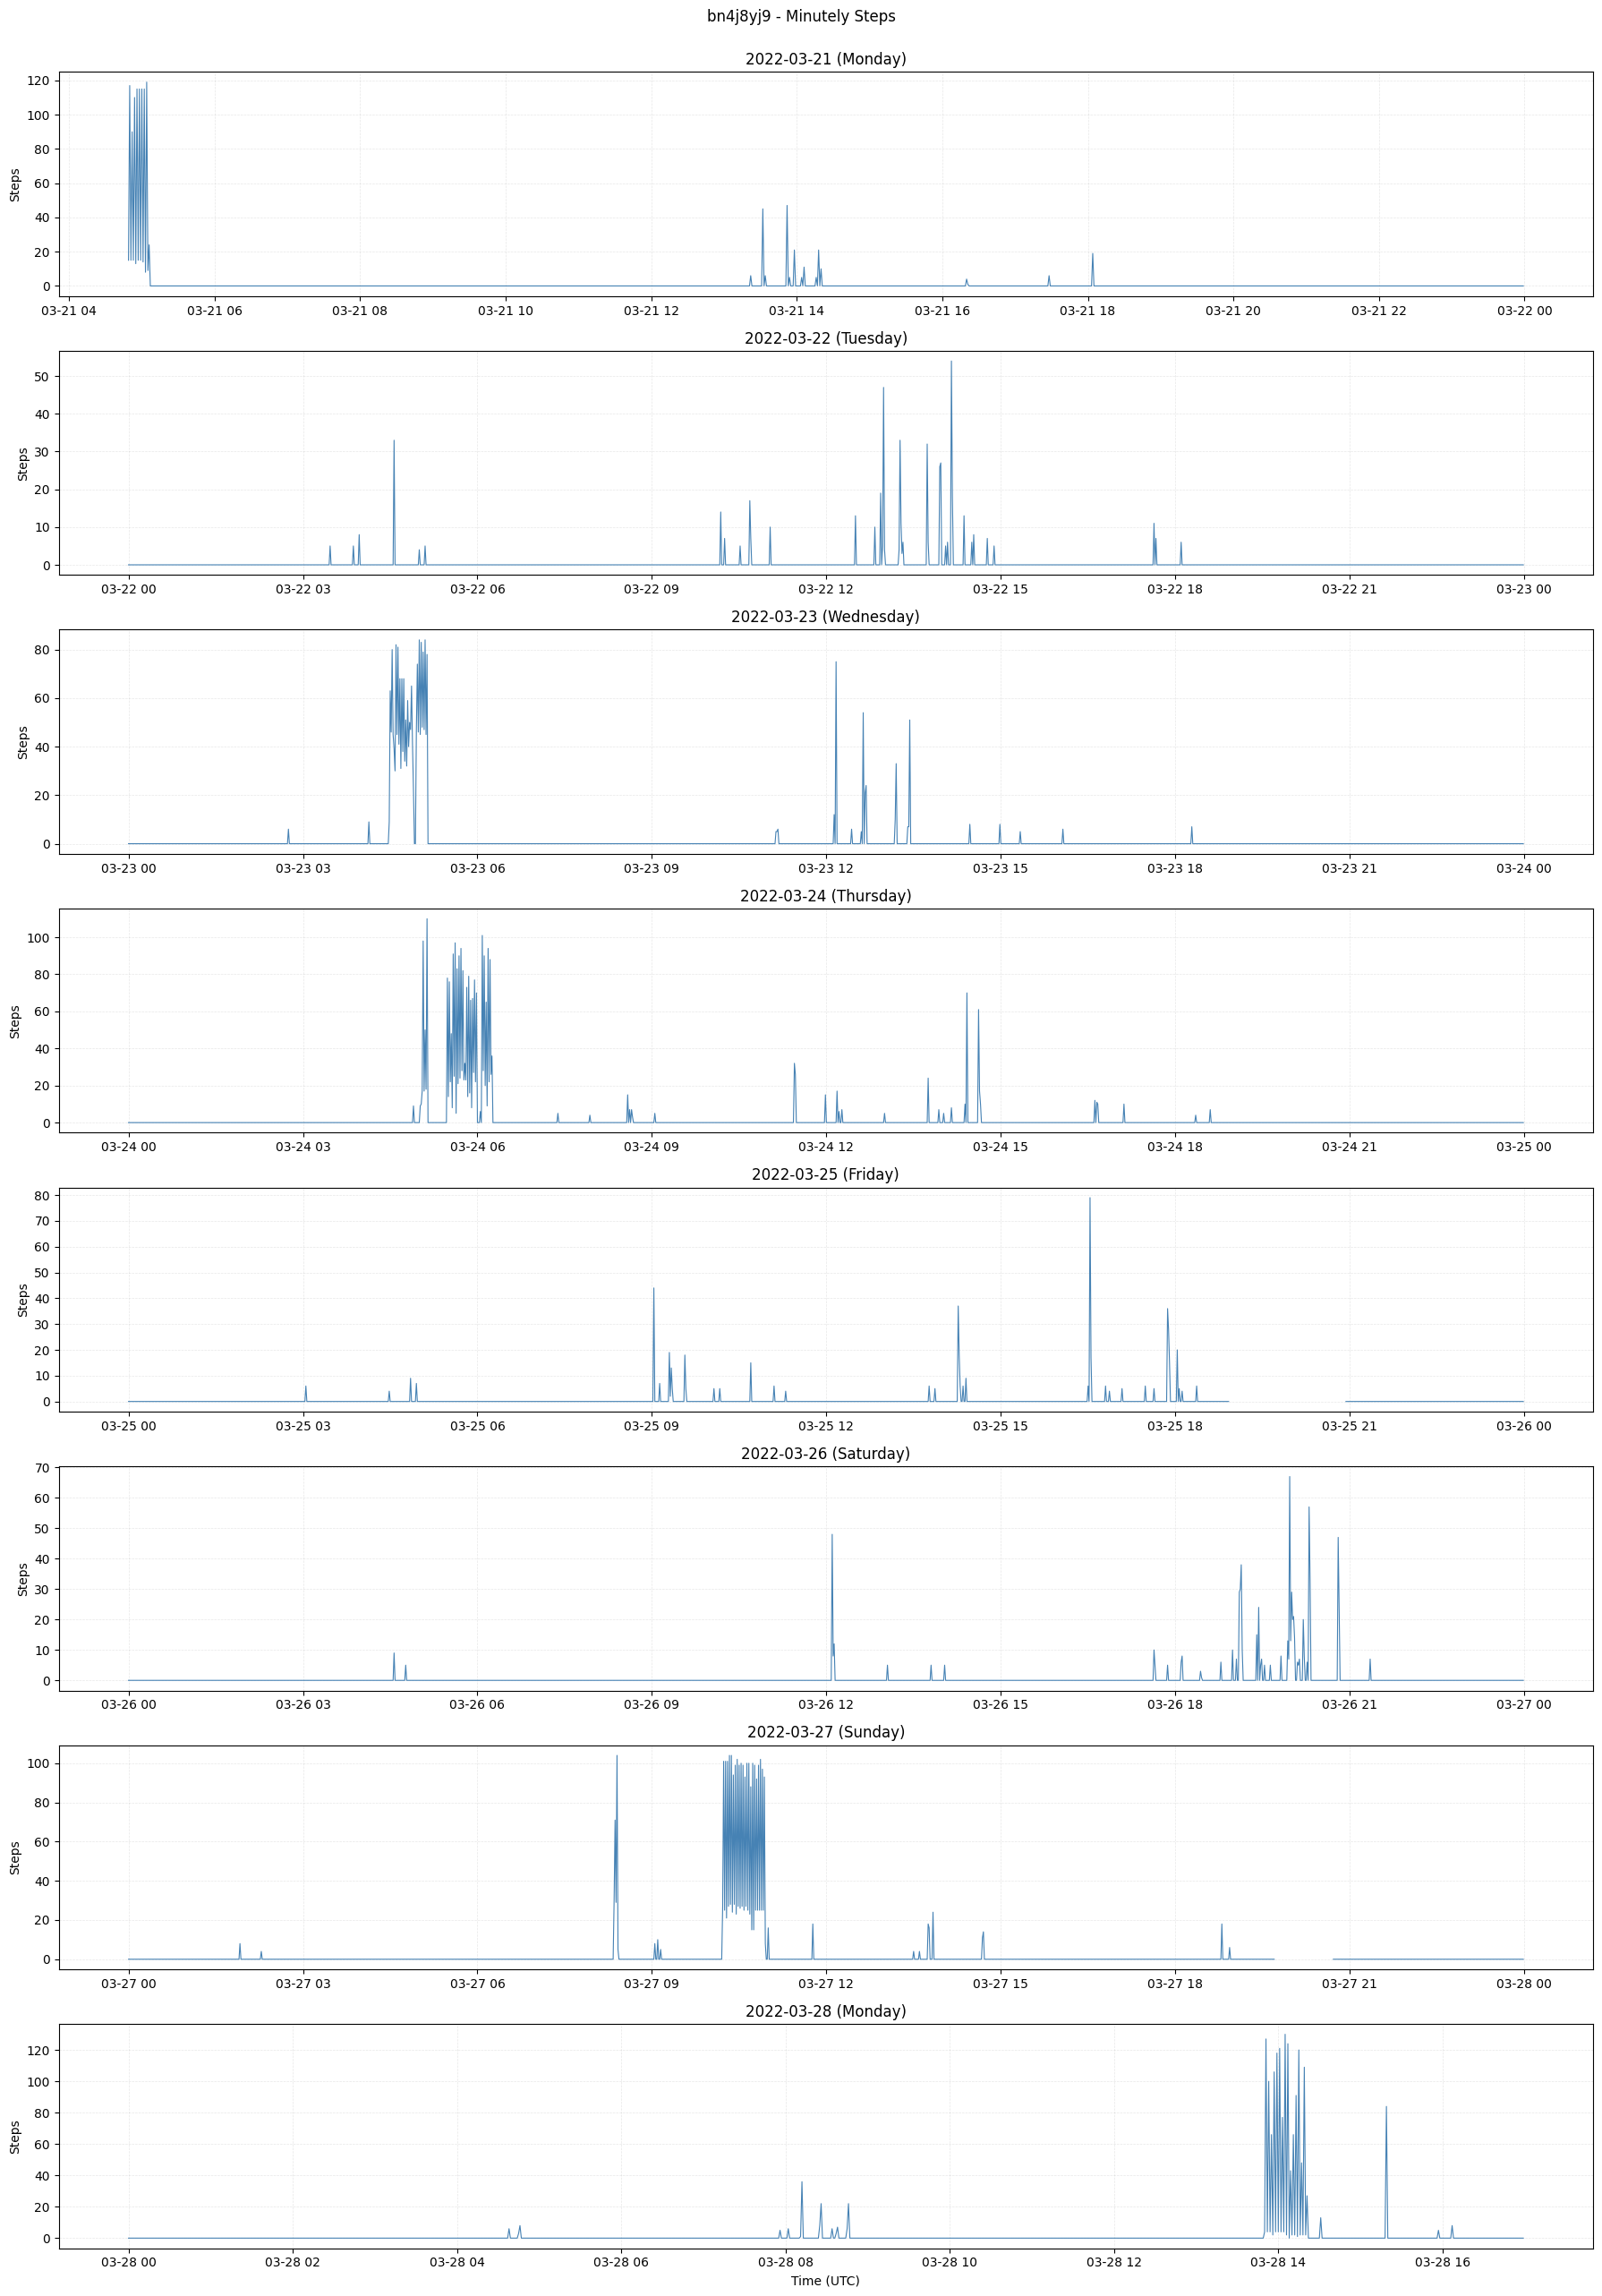


Plotting gq36edfi...


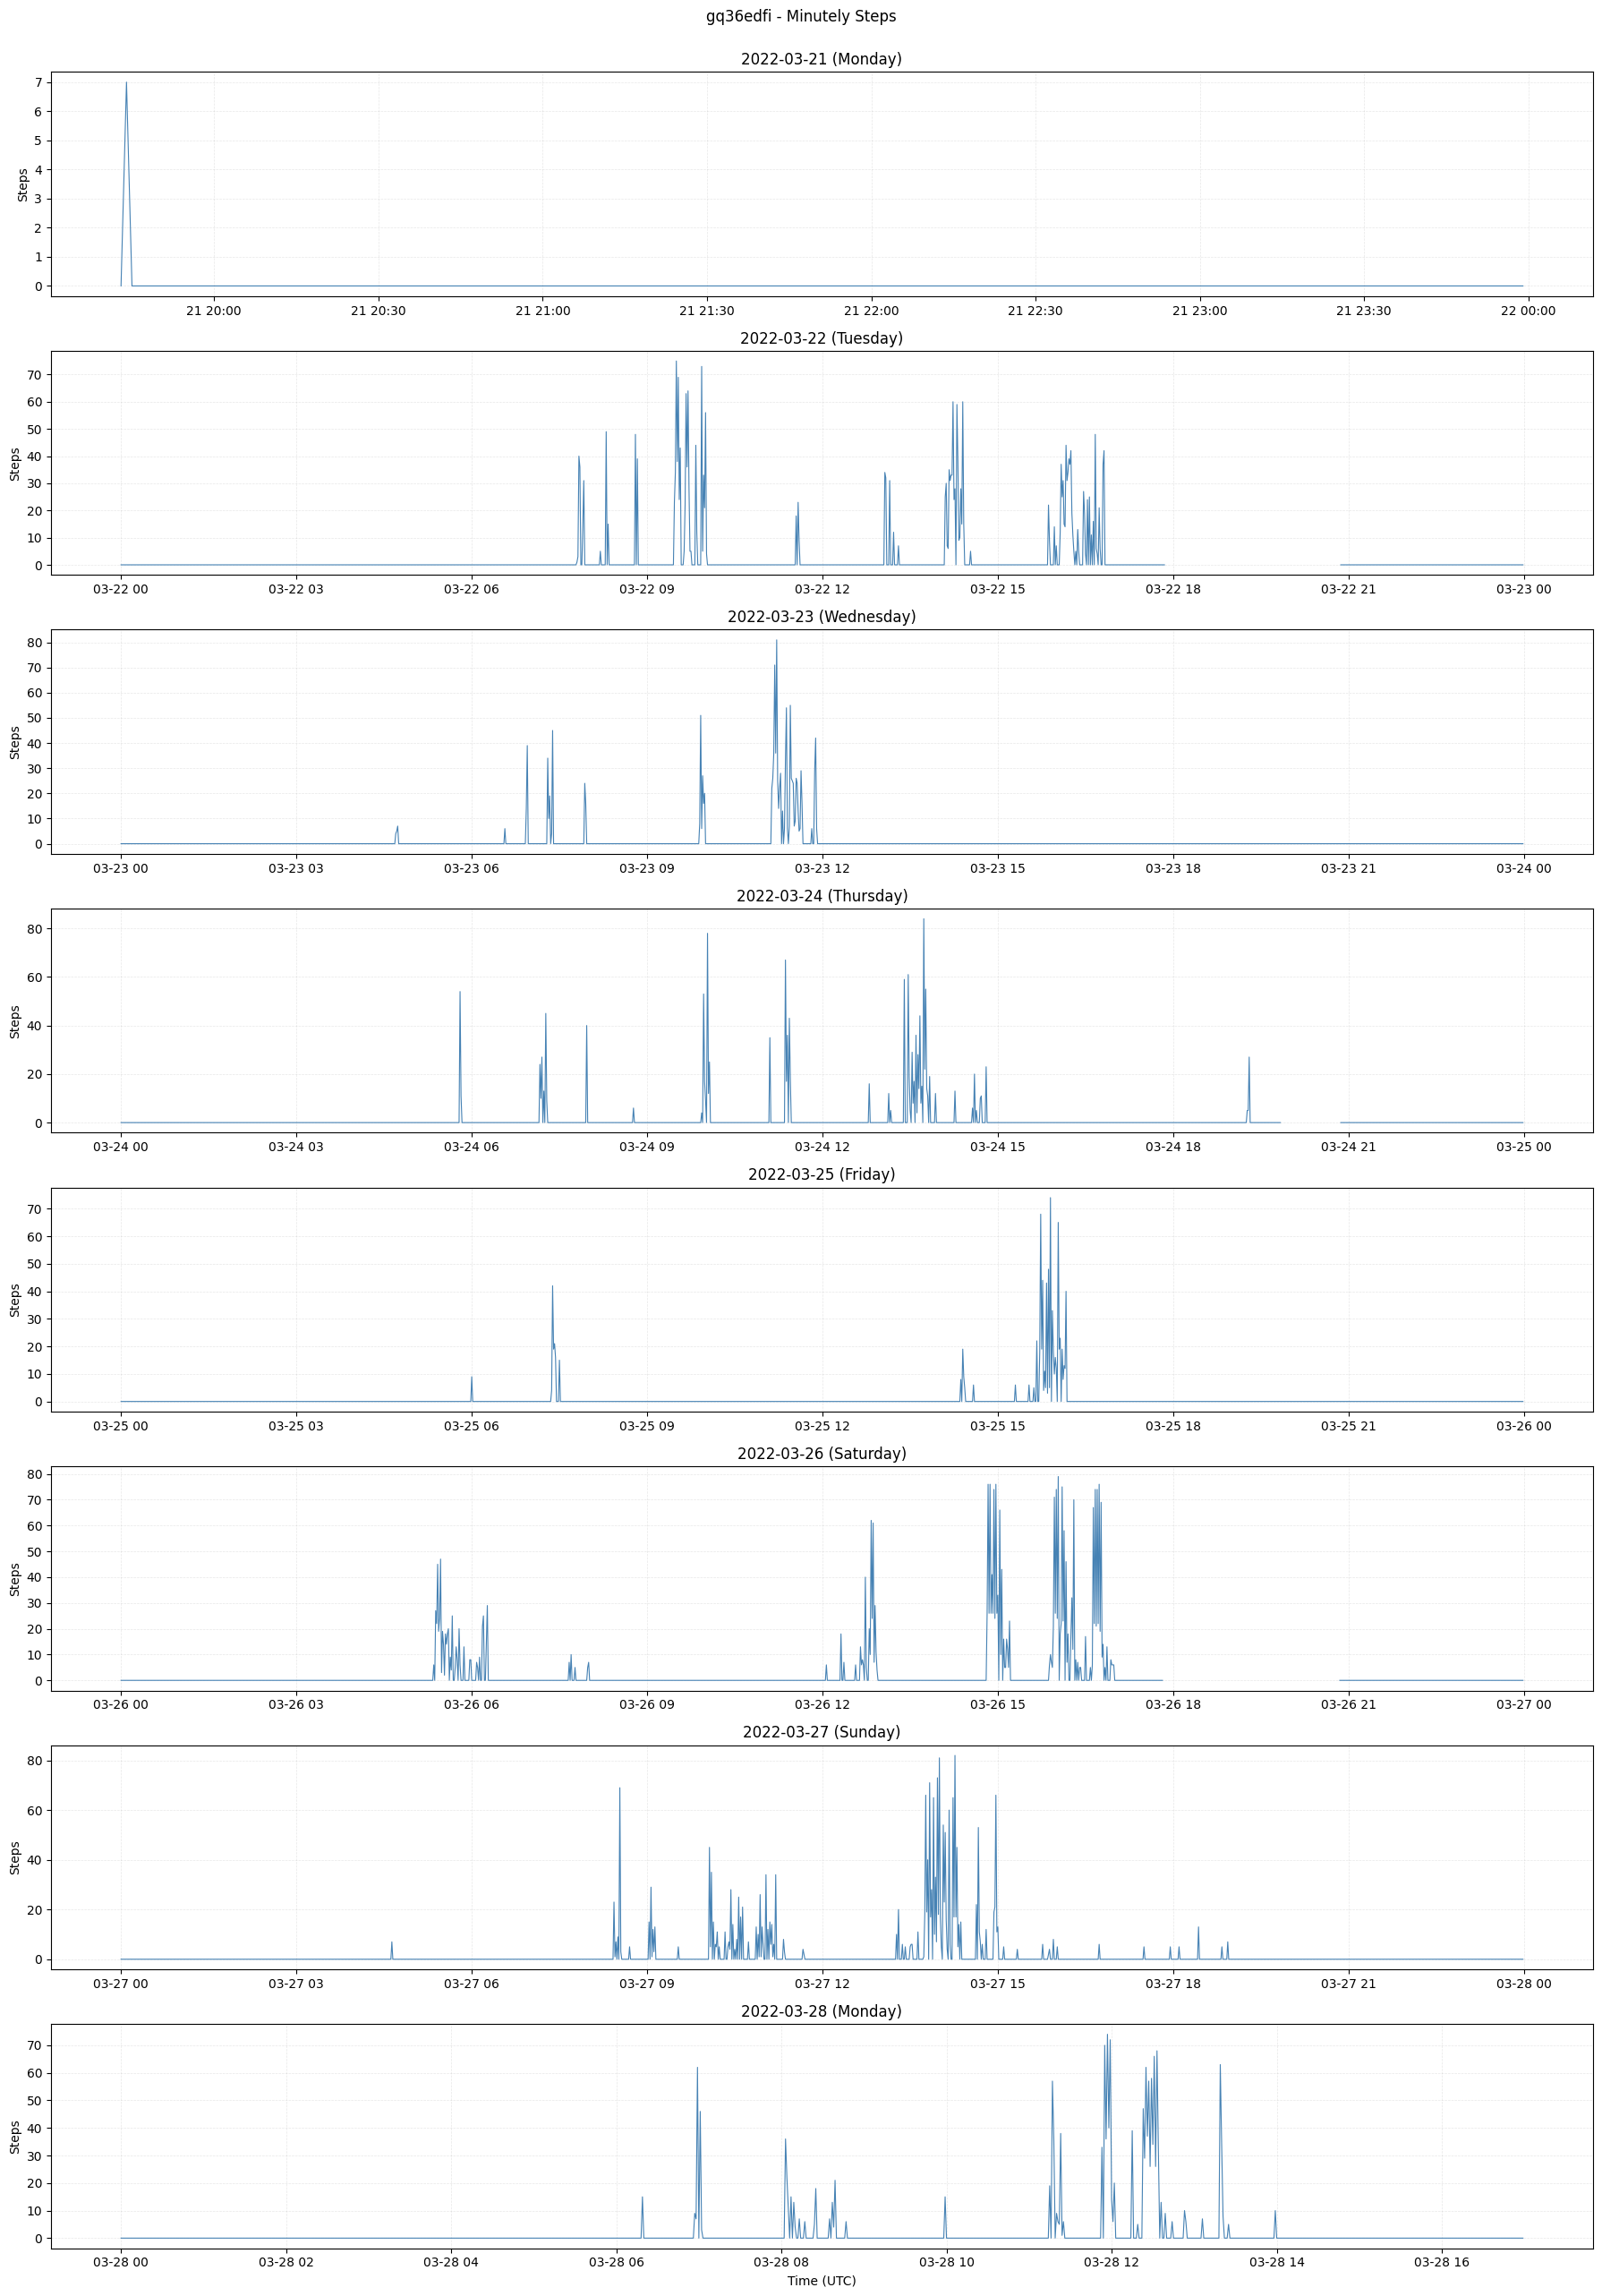


Plotting ubrmuu2r...


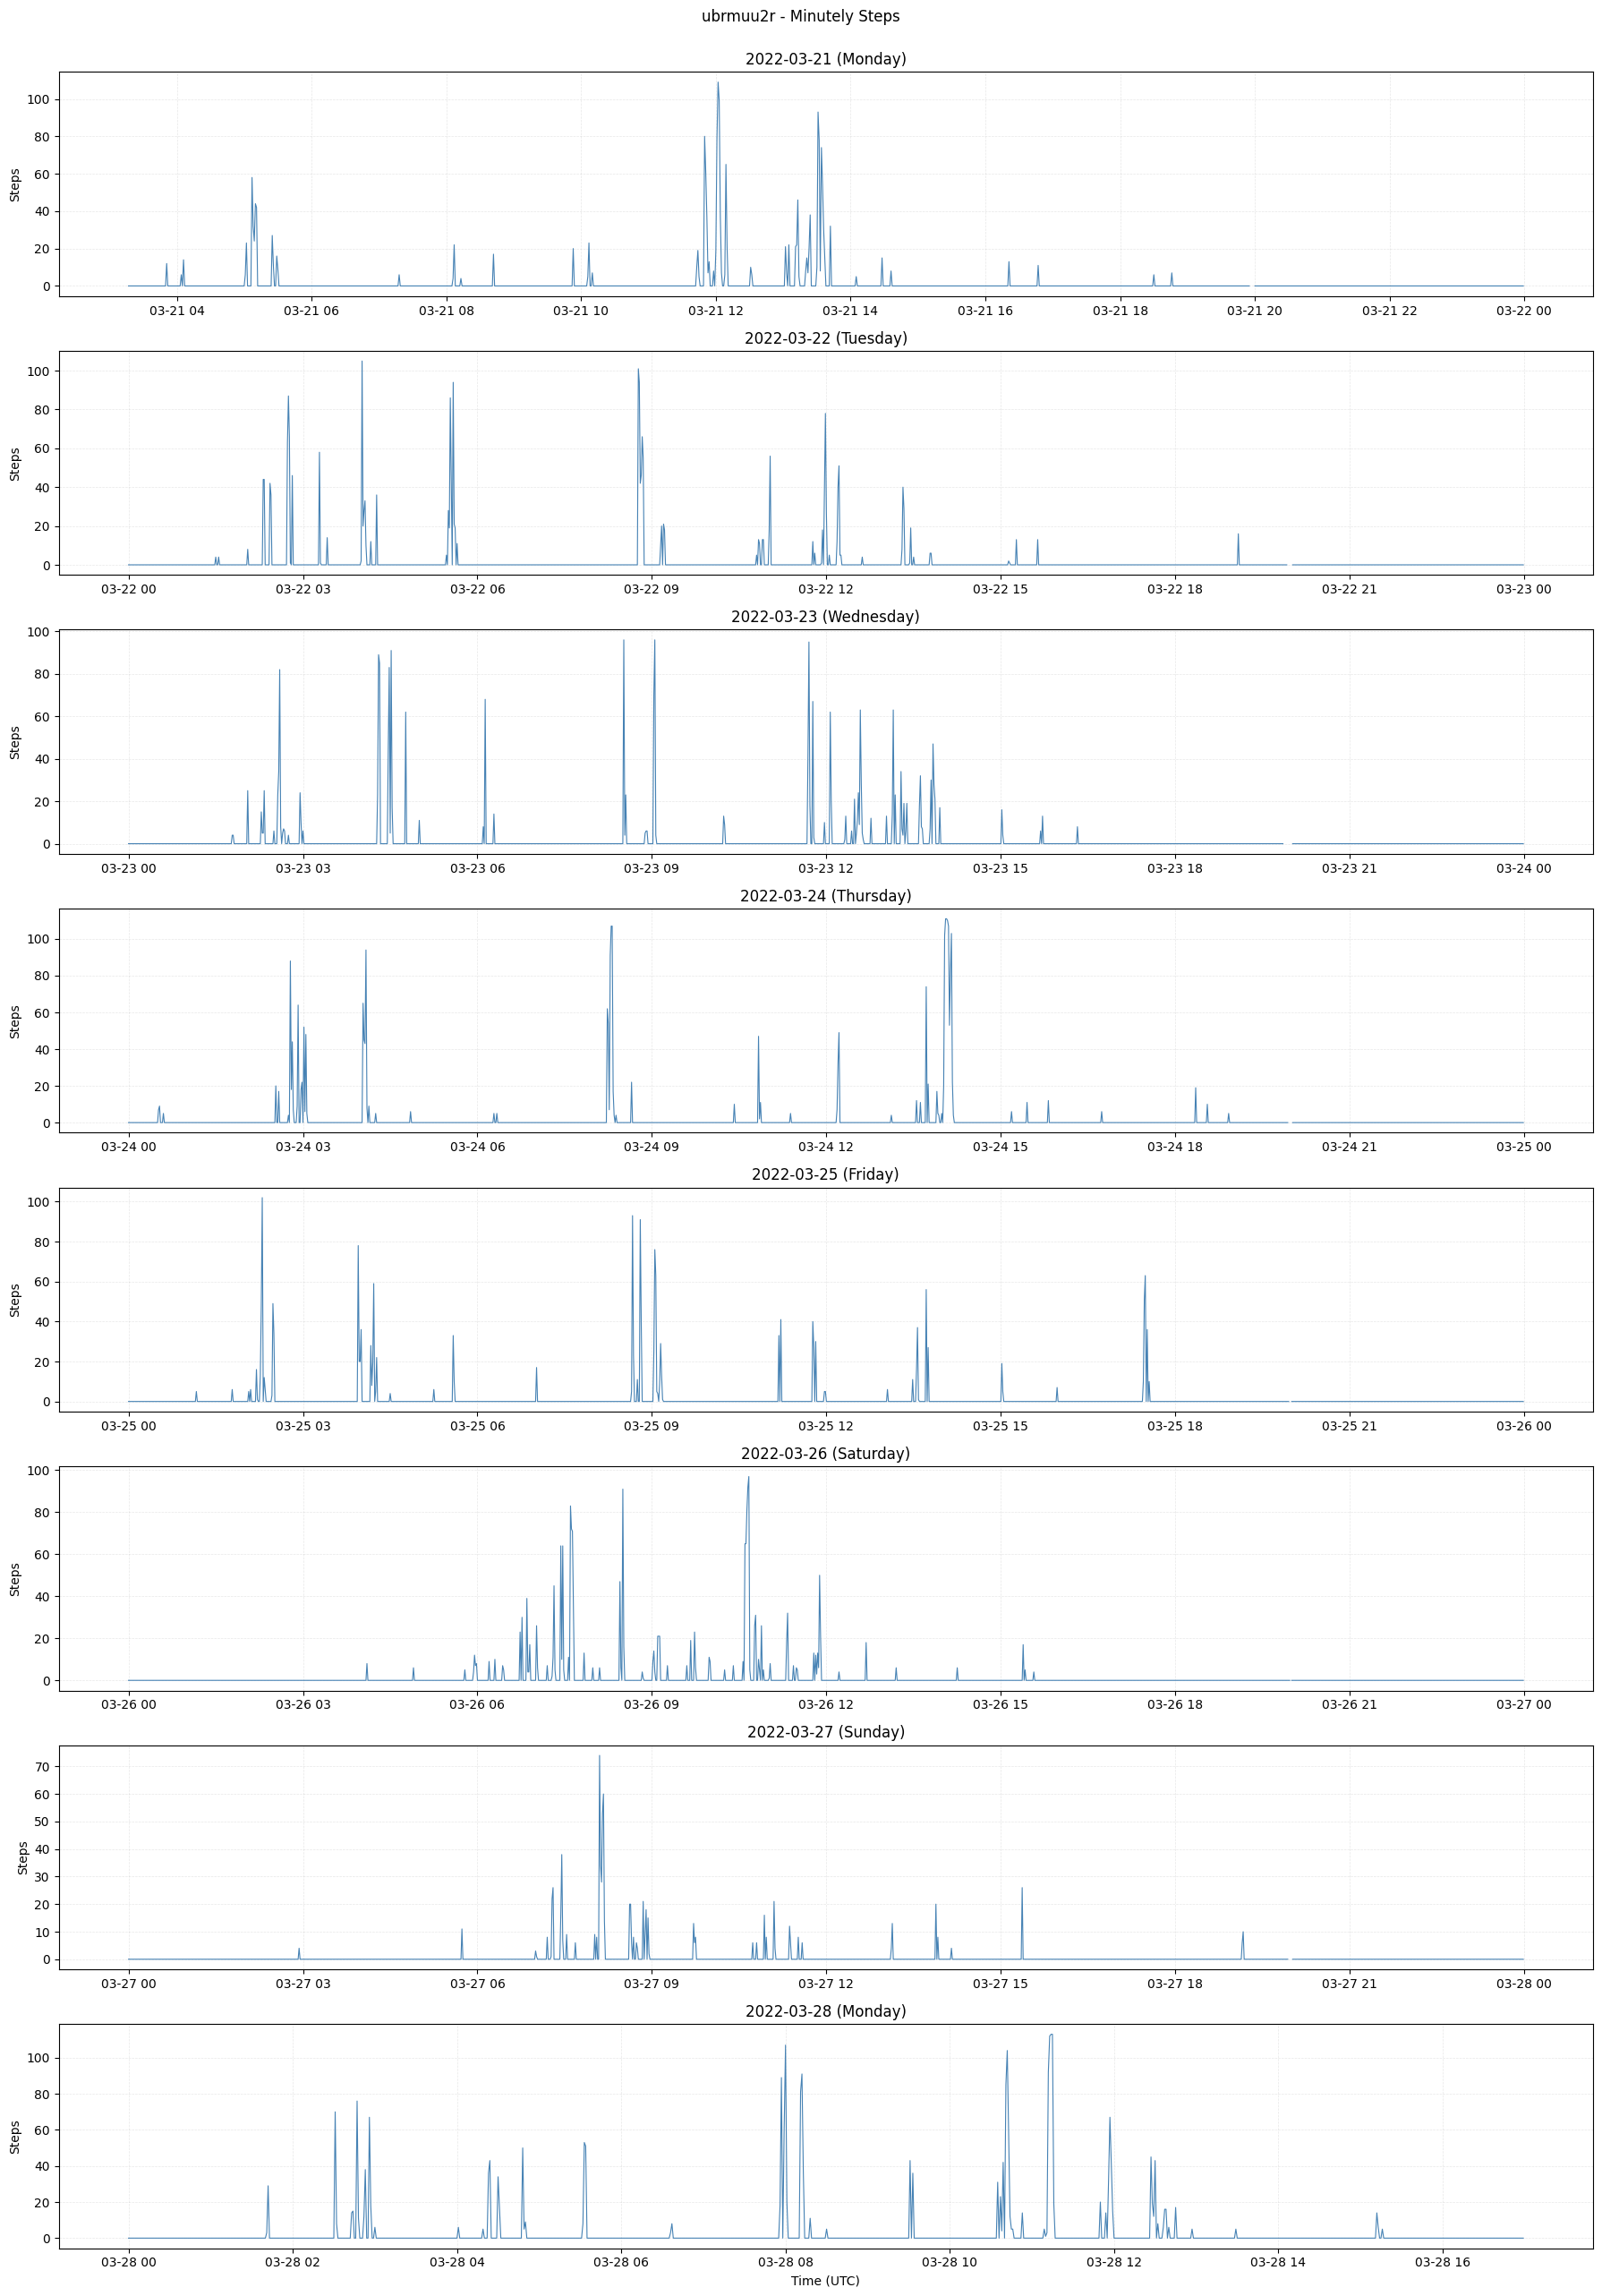


Plotting xwyd72l9...


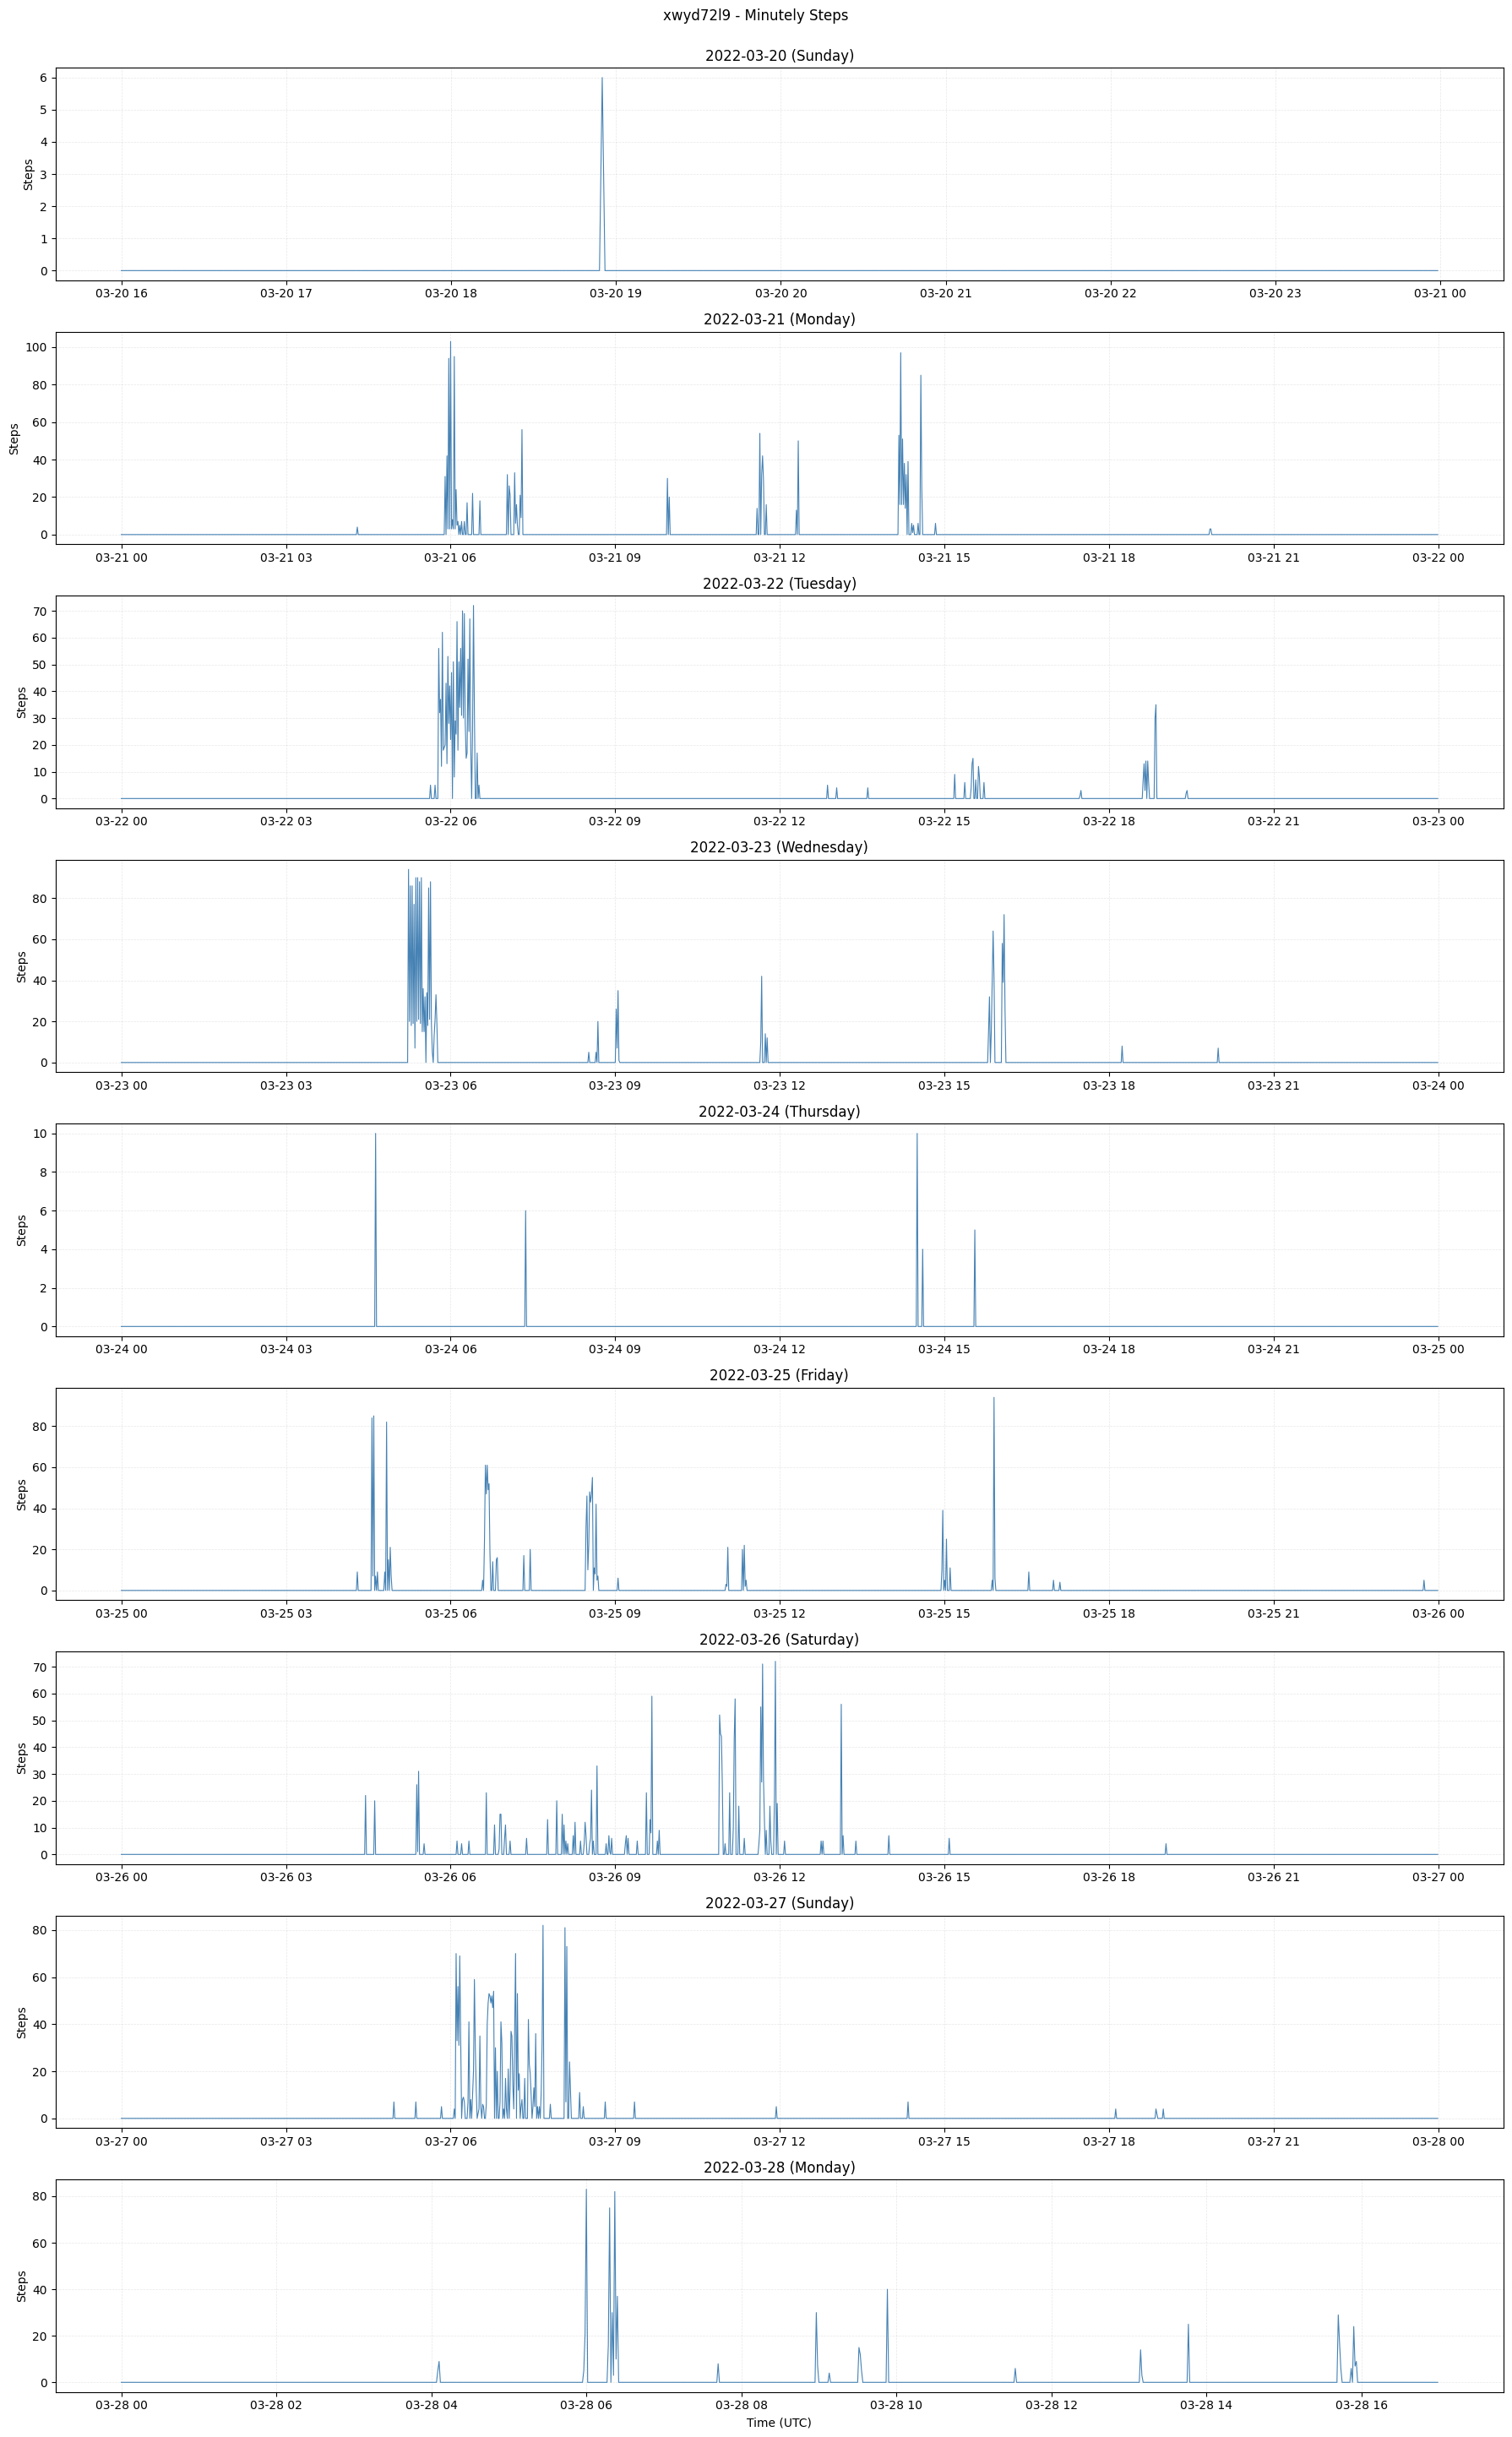


Plotting zg5uqa5l...


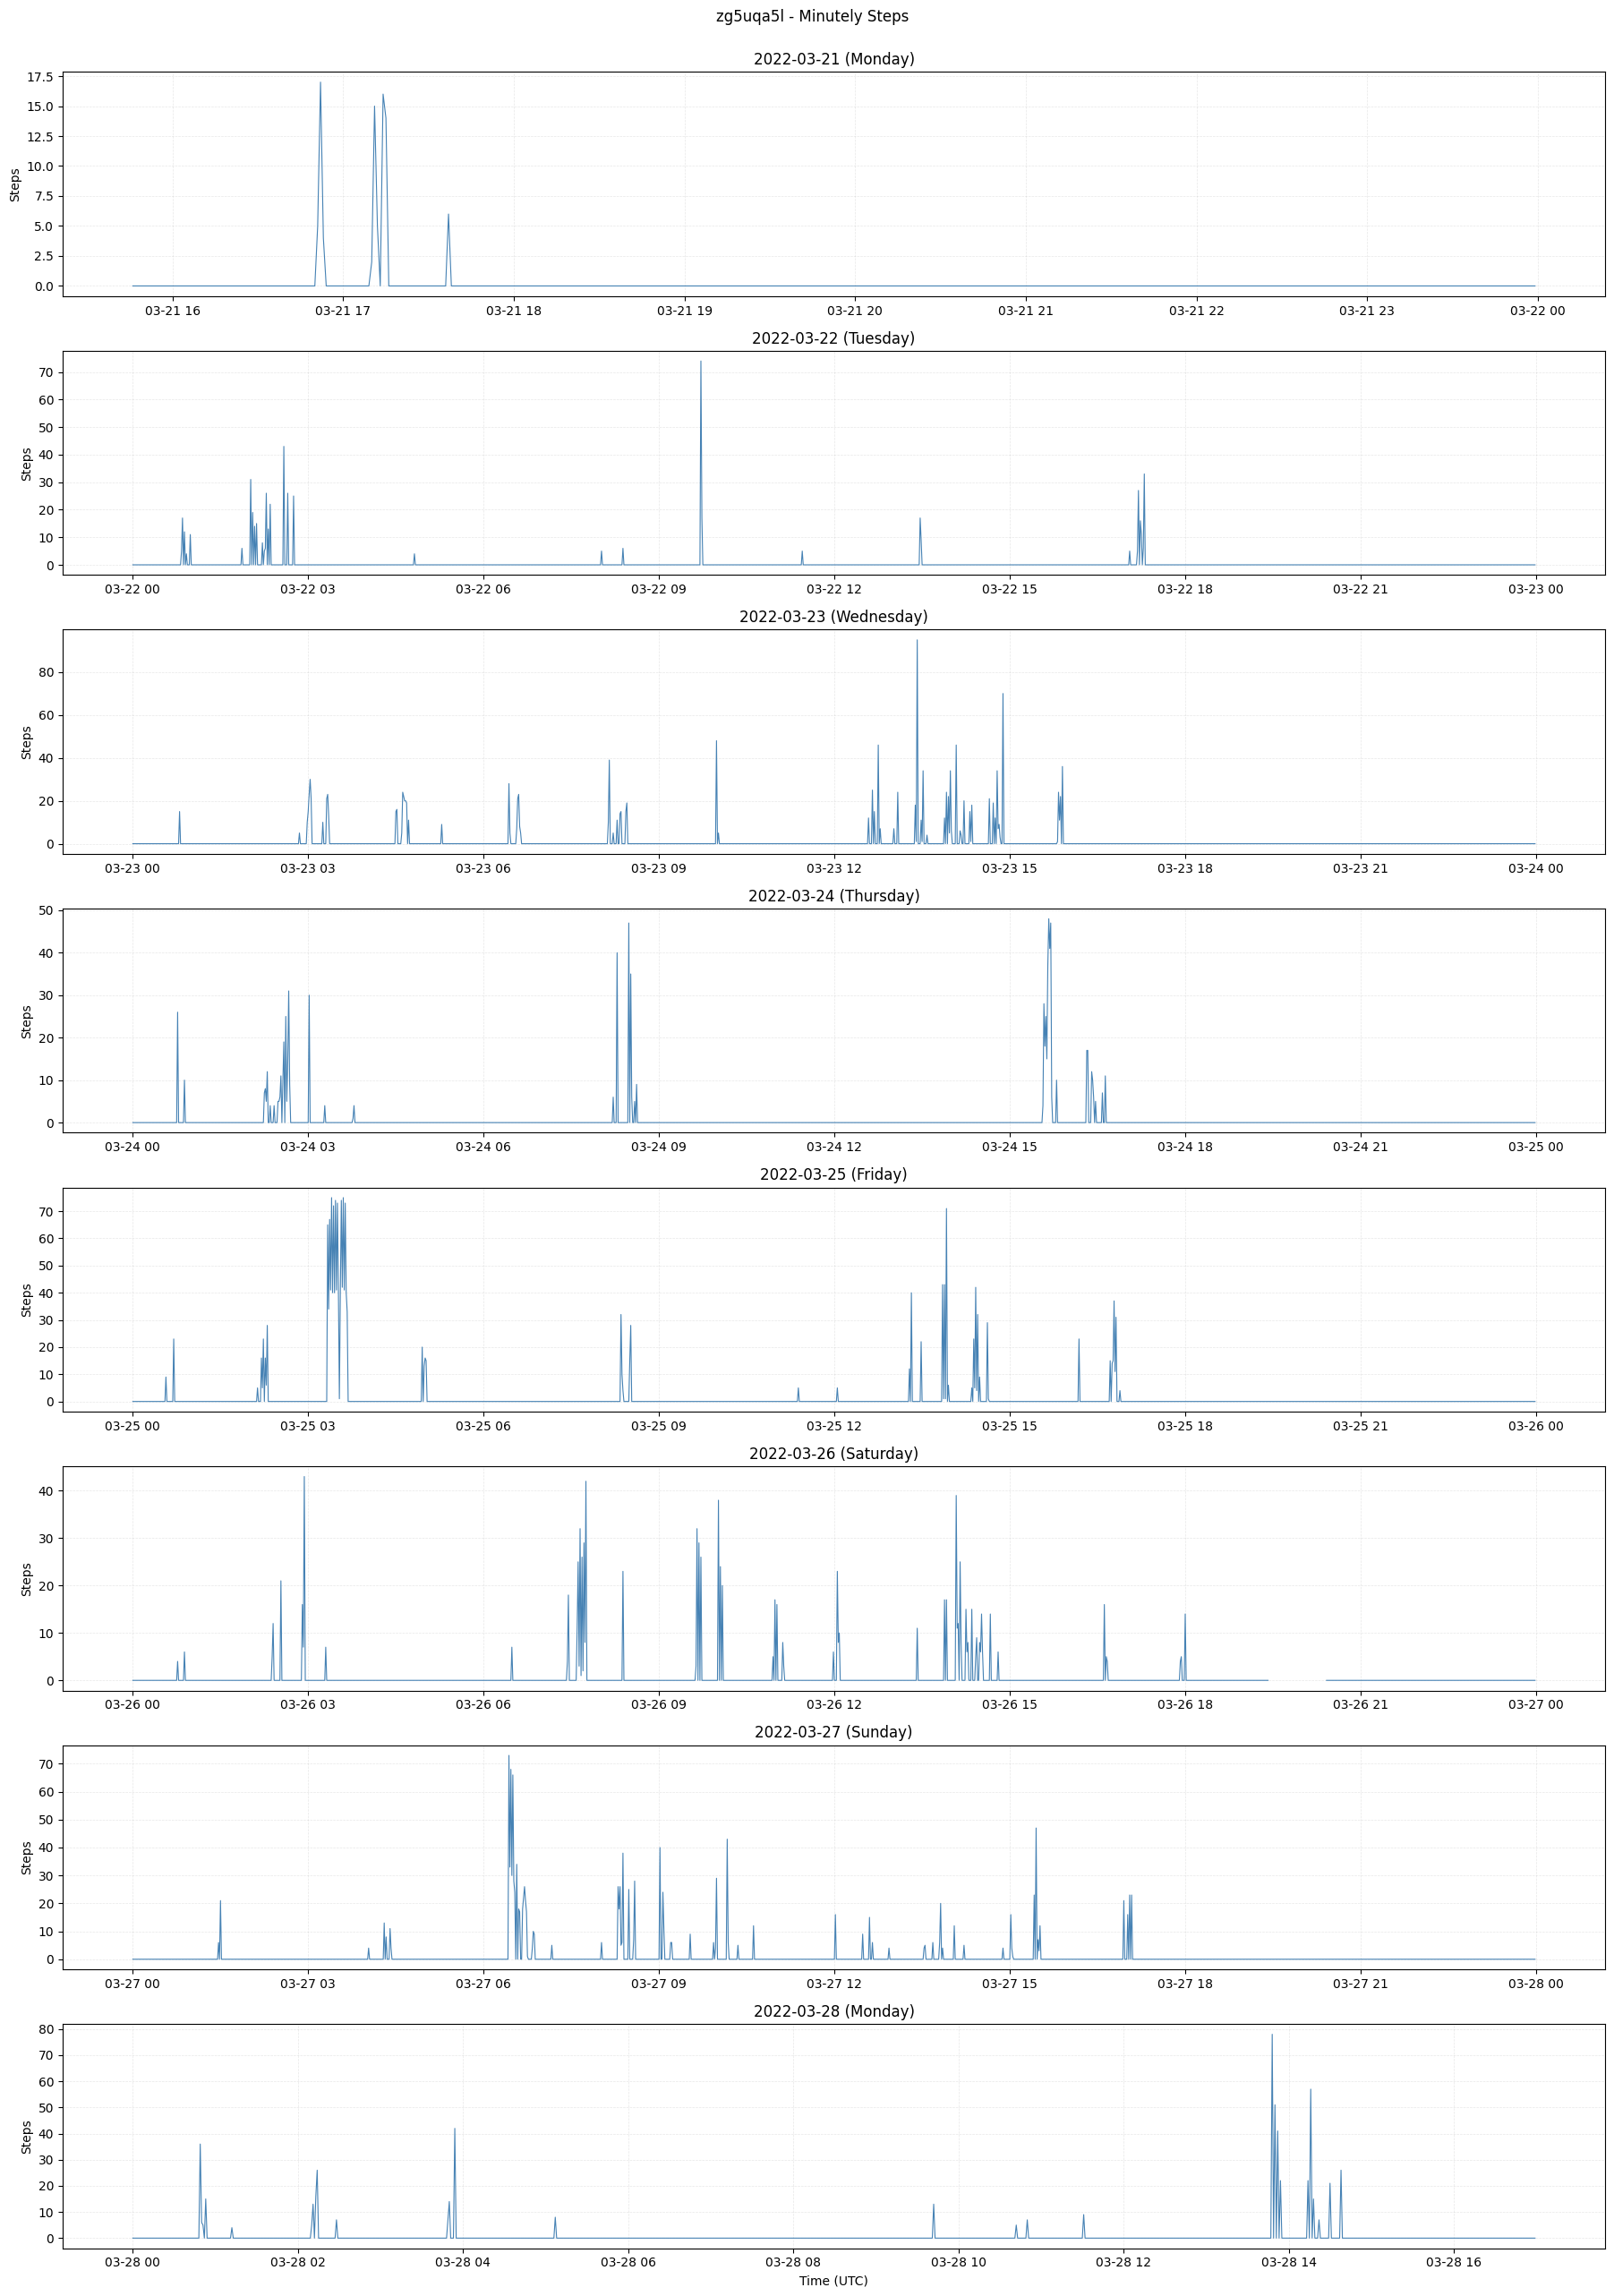

In [ ]:
# Plot minutely step counts by day for each participant
for subject_id, steps_df in forest_results.items():
    print(f'\nPlotting {subject_id}...')
    
    # Add date column for grouping
    plot_df = steps_df.copy()
    plot_df['date'] = plot_df['timestamp'].dt.date
    unique_dates = sorted(plot_df['date'].unique())
    num_days = len(unique_dates)
    
    if num_days == 0:
        print('  No dates to plot.')
        continue
    
    fig, axes = plt.subplots(num_days, 1, figsize=(18, 3.2 * num_days), sharex=False)
    if num_days == 1:
        axes = [axes]
    
    for ax, day in zip(axes, unique_dates):
        day_df = plot_df[plot_df['date'] == day]
        times = day_df['timestamp']
        
        # Plot steps as line chart (like MIMS)
        ax.plot(times, day_df['steps'], color='steelblue', linewidth=0.8)
        
        weekday = pd.Timestamp(day).strftime('%A')
        ax.set_title(f'{day} ({weekday})')
        ax.set_ylabel('Steps')
        ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    
    axes[-1].set_xlabel('Time (UTC)')
    fig.suptitle(f'{subject_id} - Minutely Steps', y=1.0)
    plt.tight_layout()
    plt.show()


## Plot log10(Minutely Step Counts) by Day

Plot log-transformed step counts (only for positive values) for better visualization of lower activity periods.


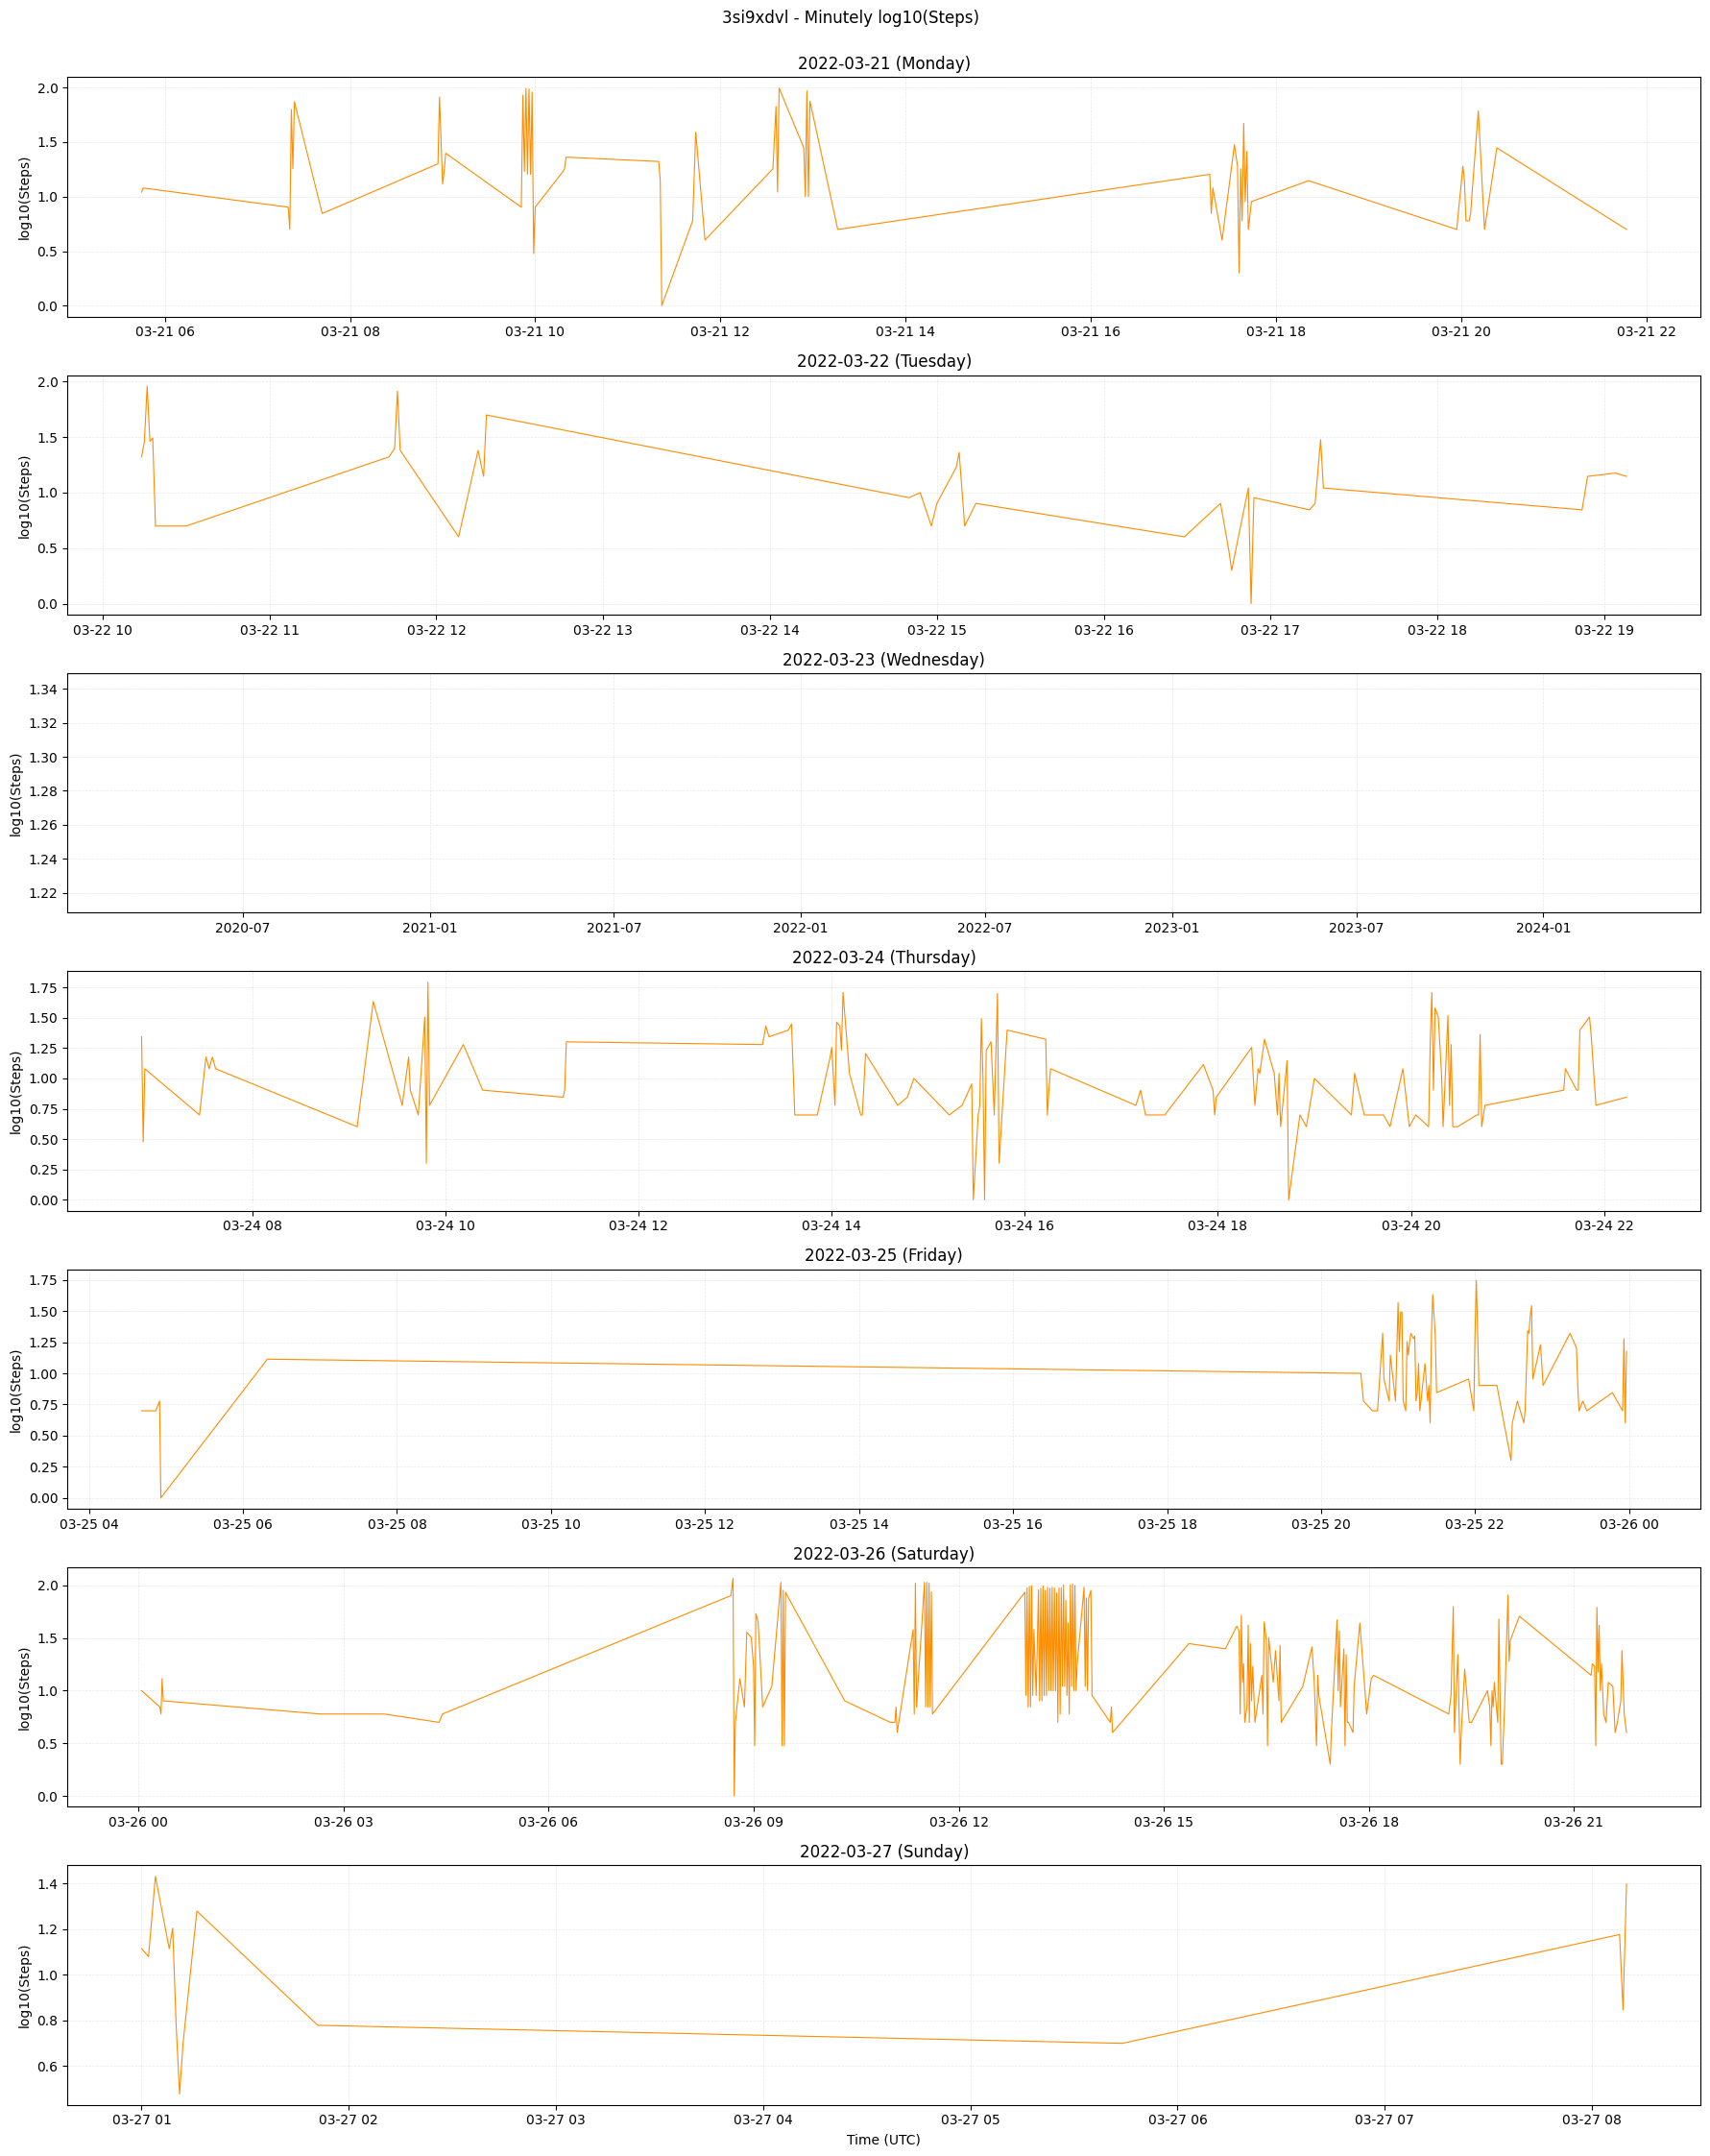

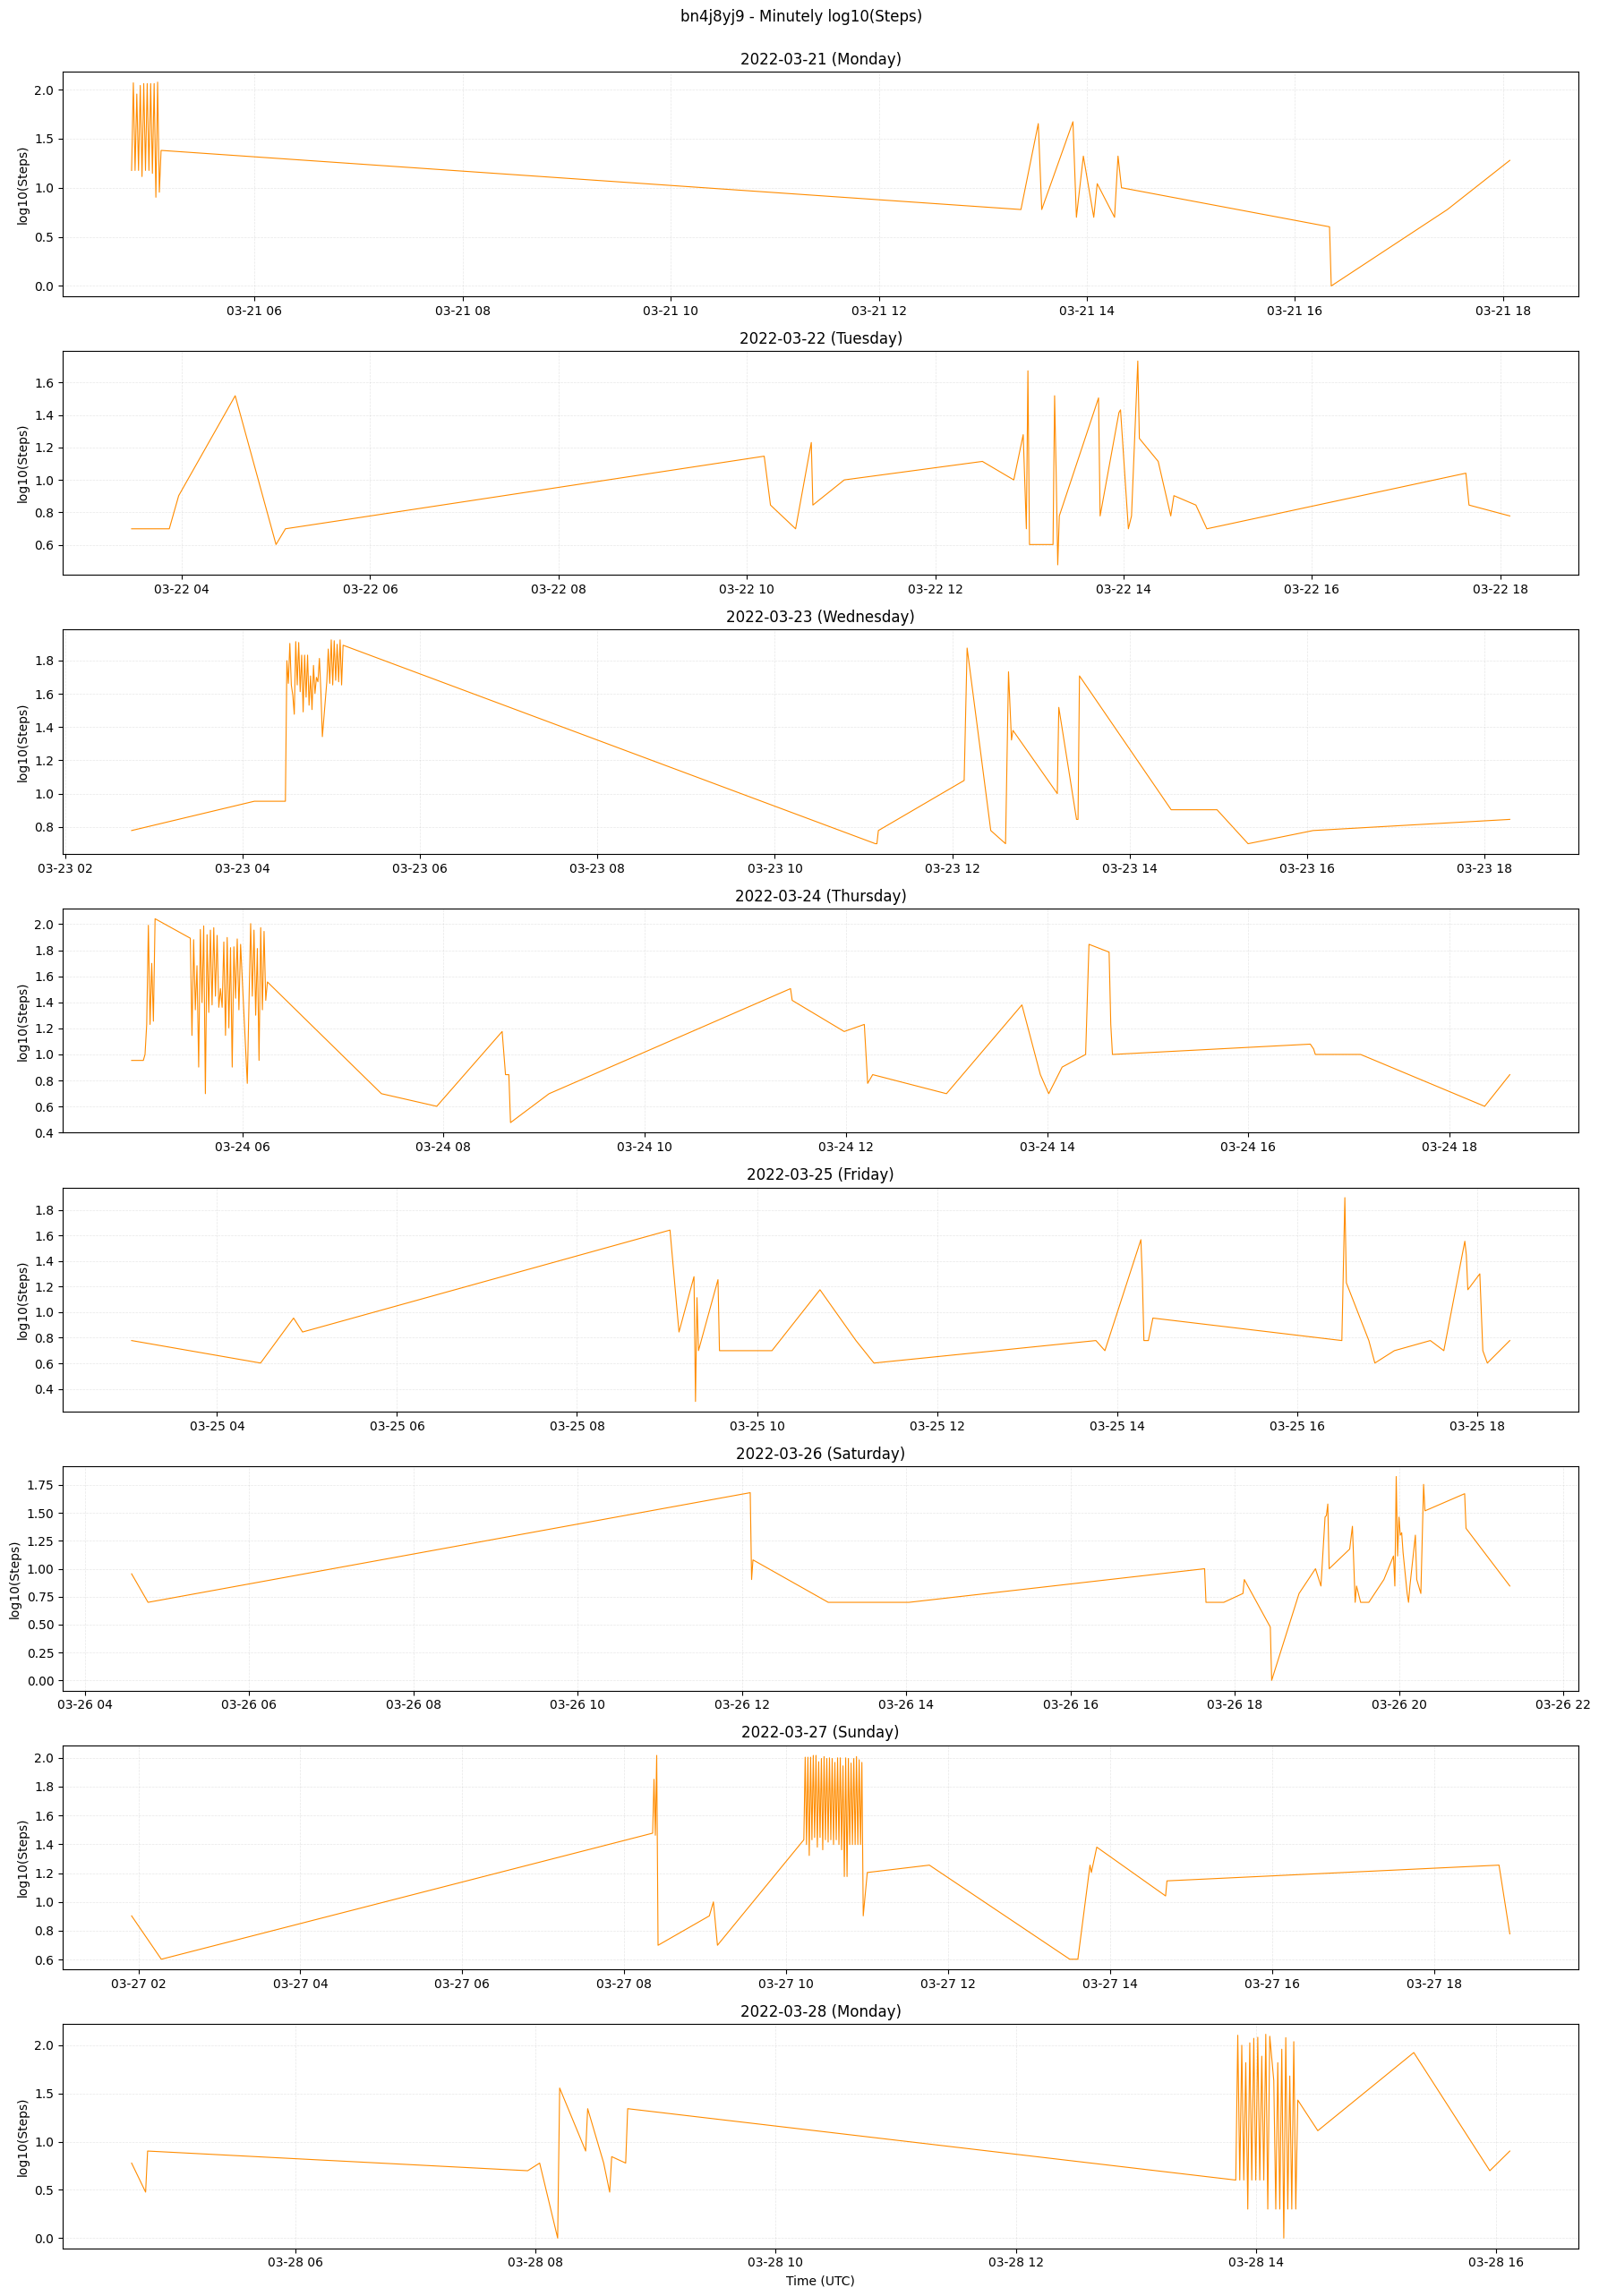

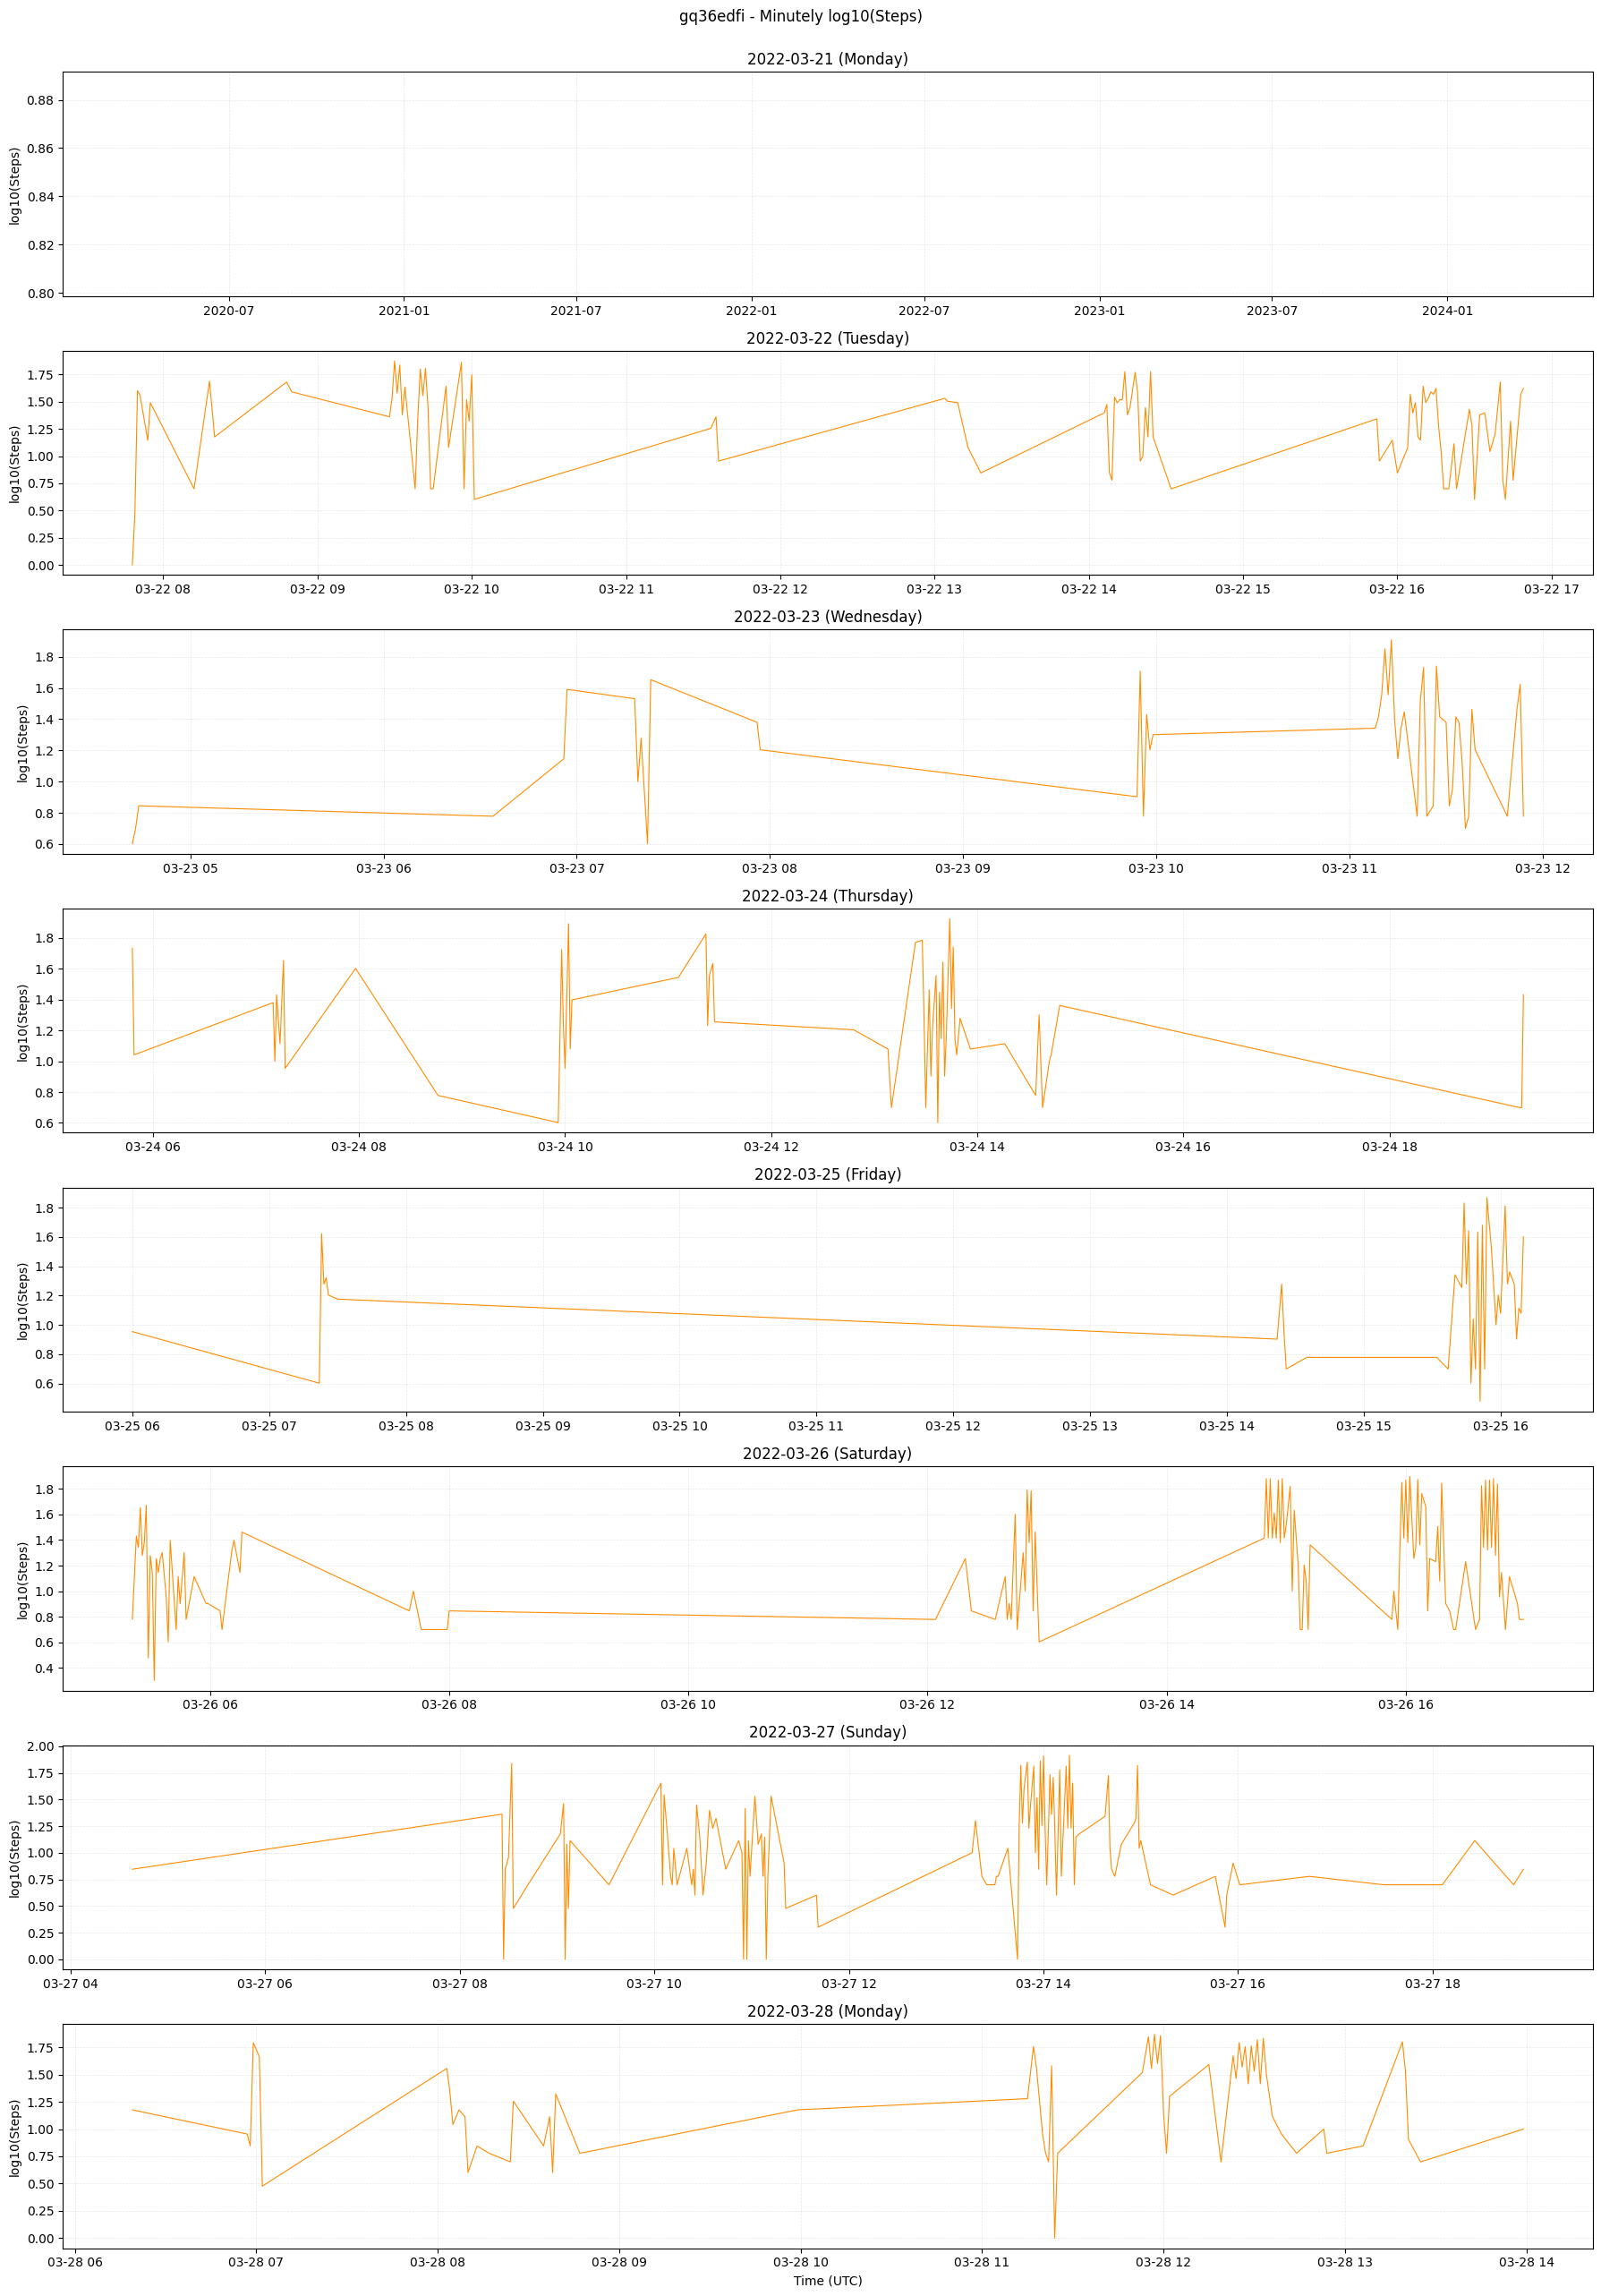

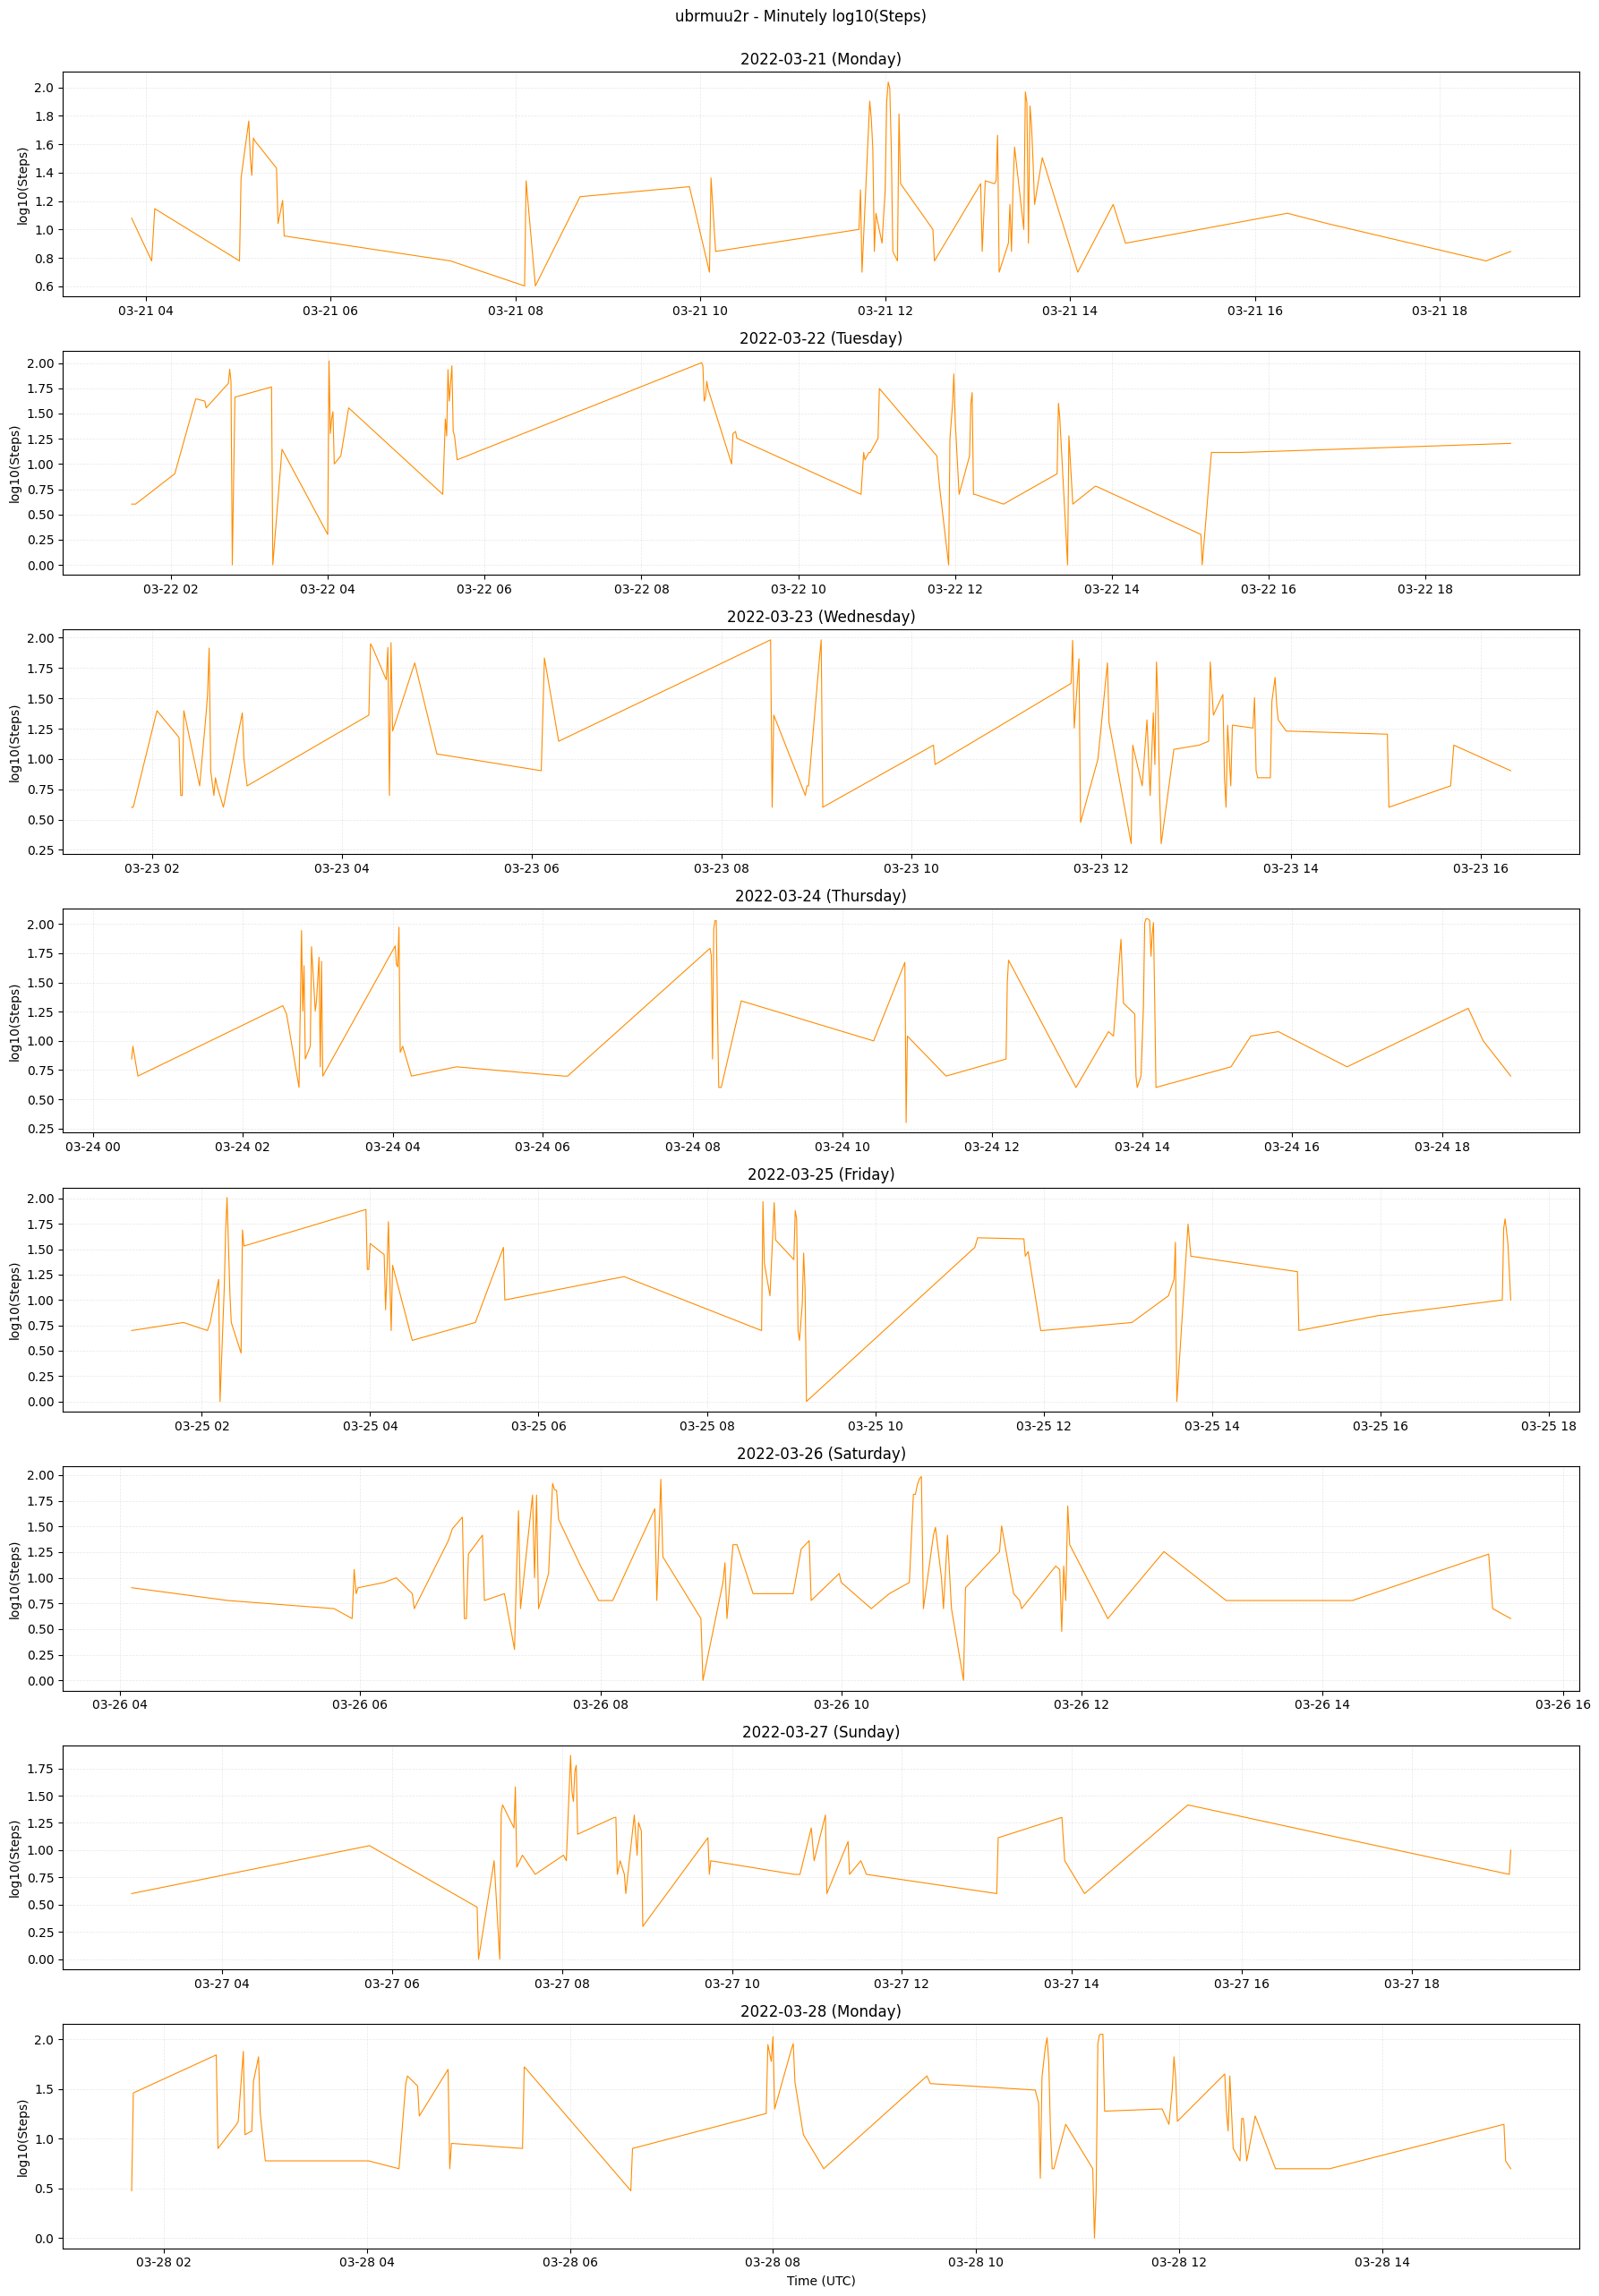

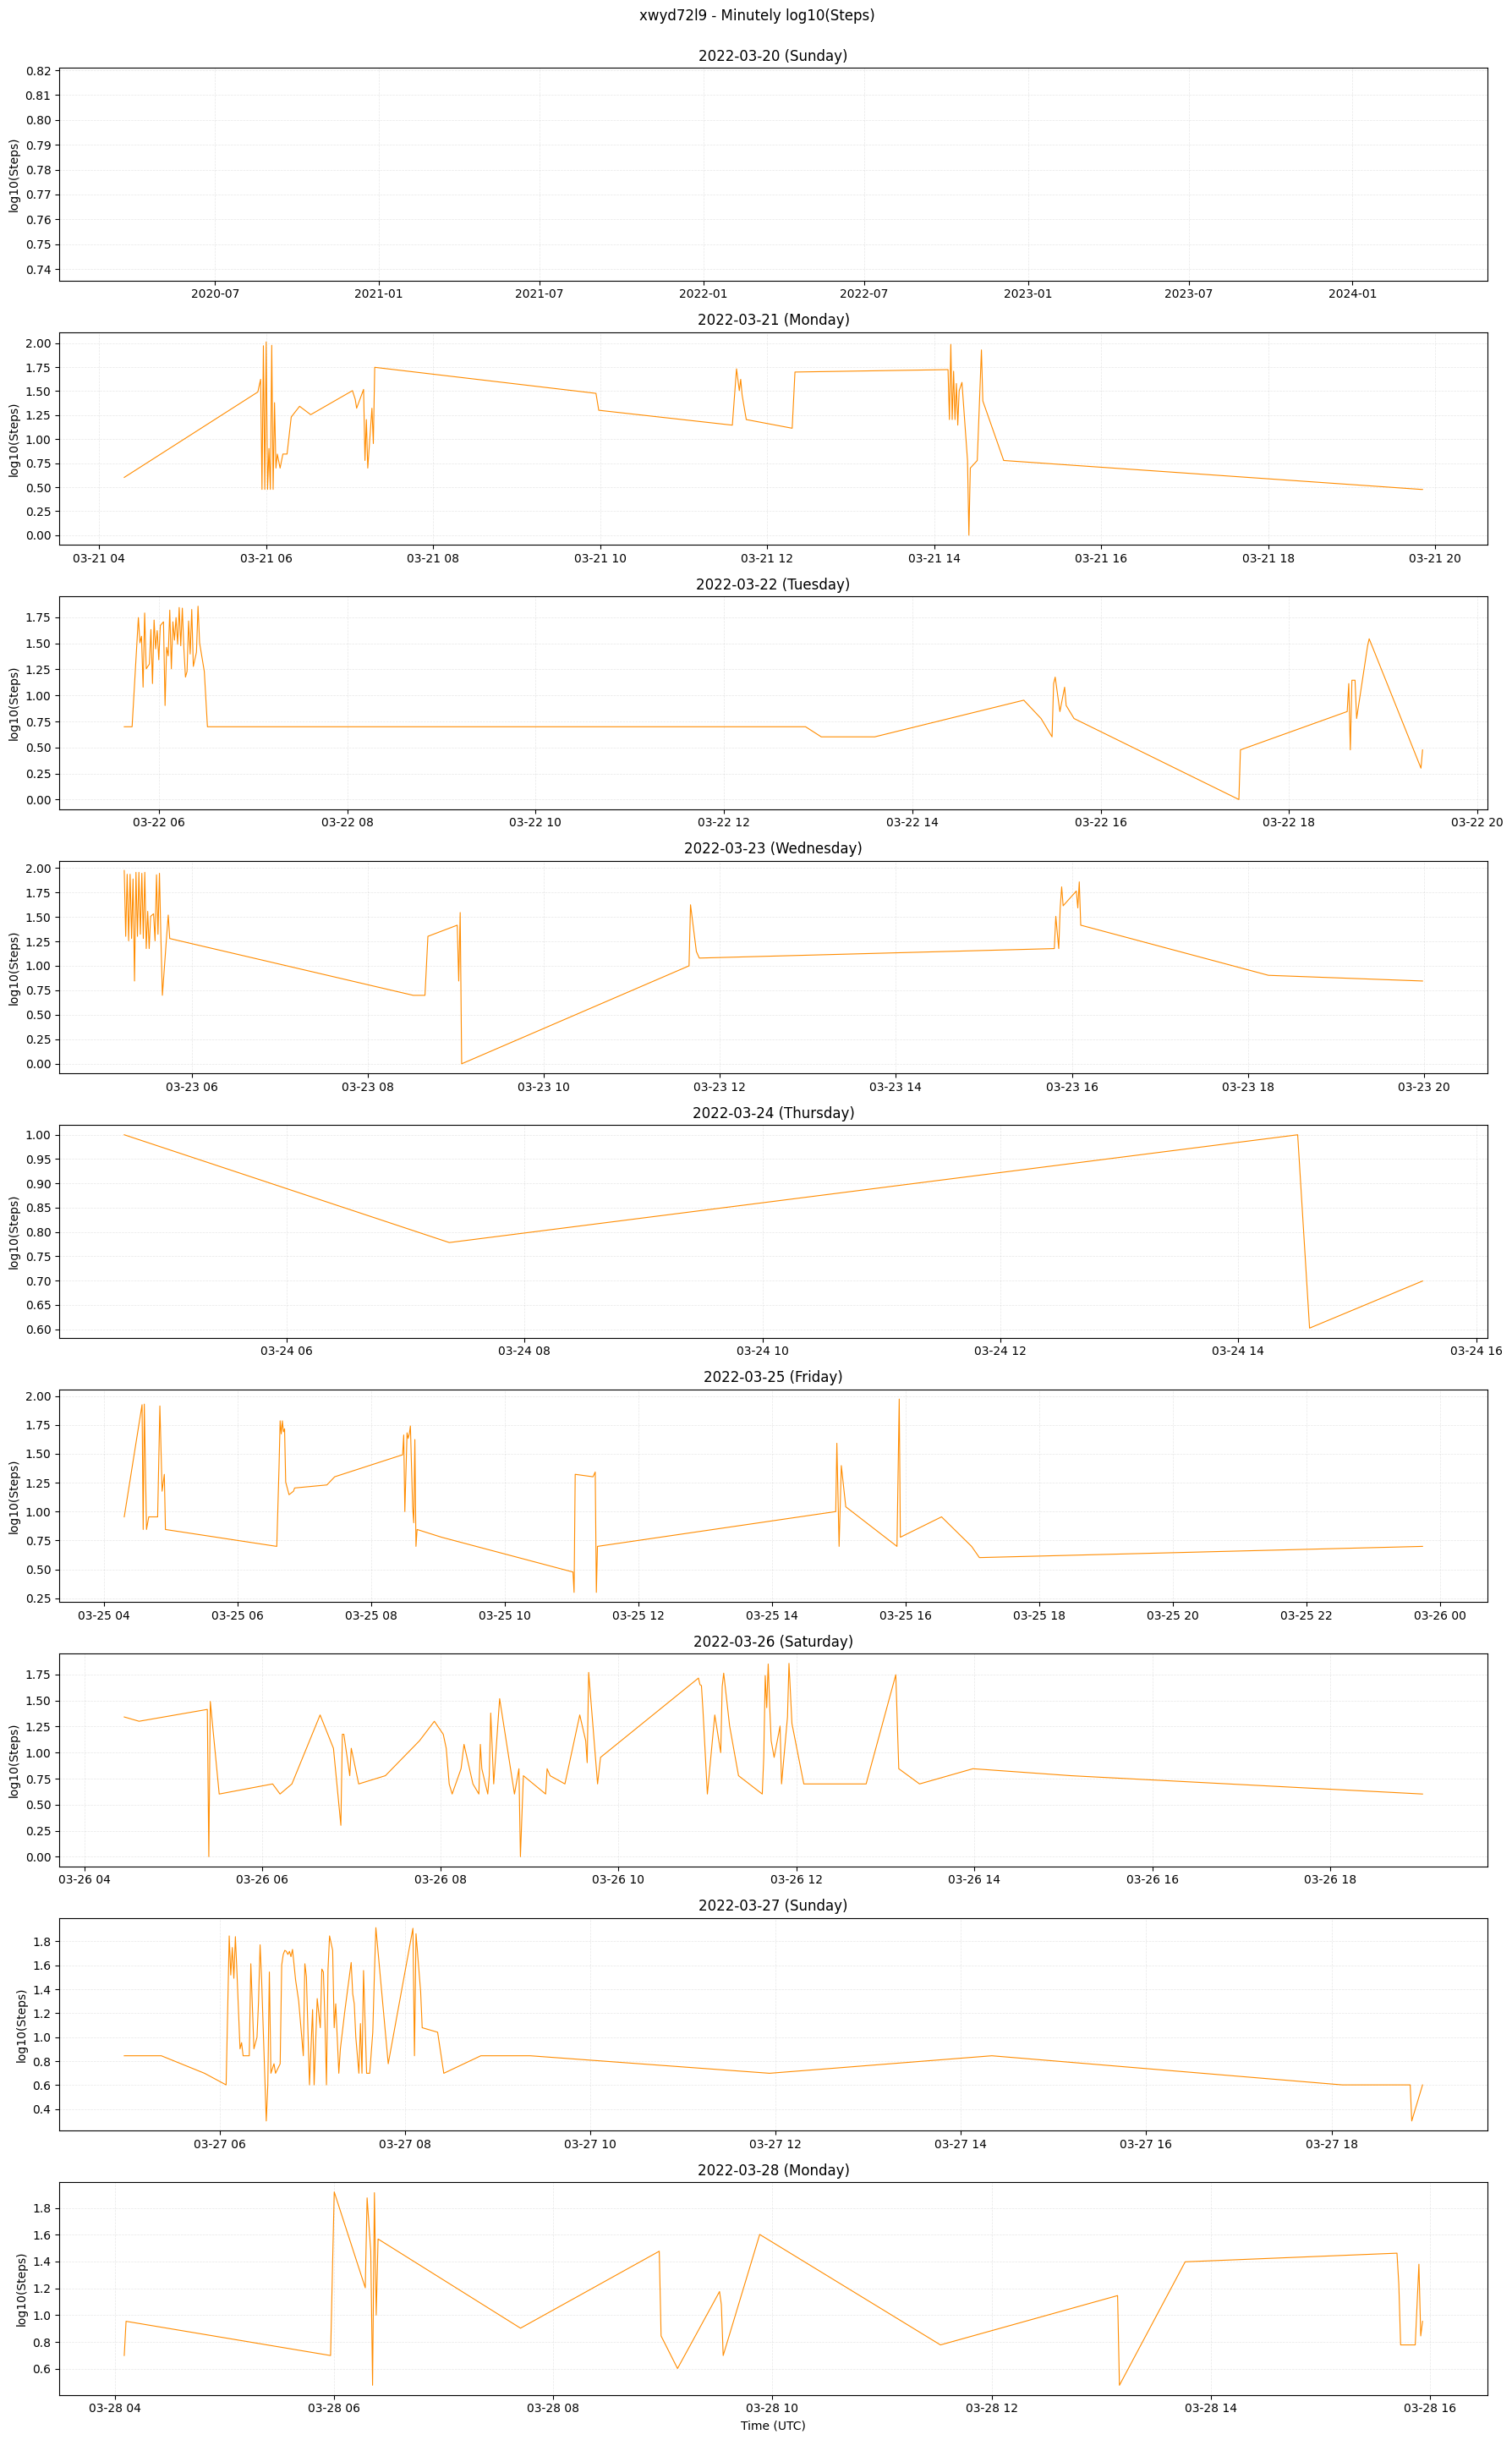

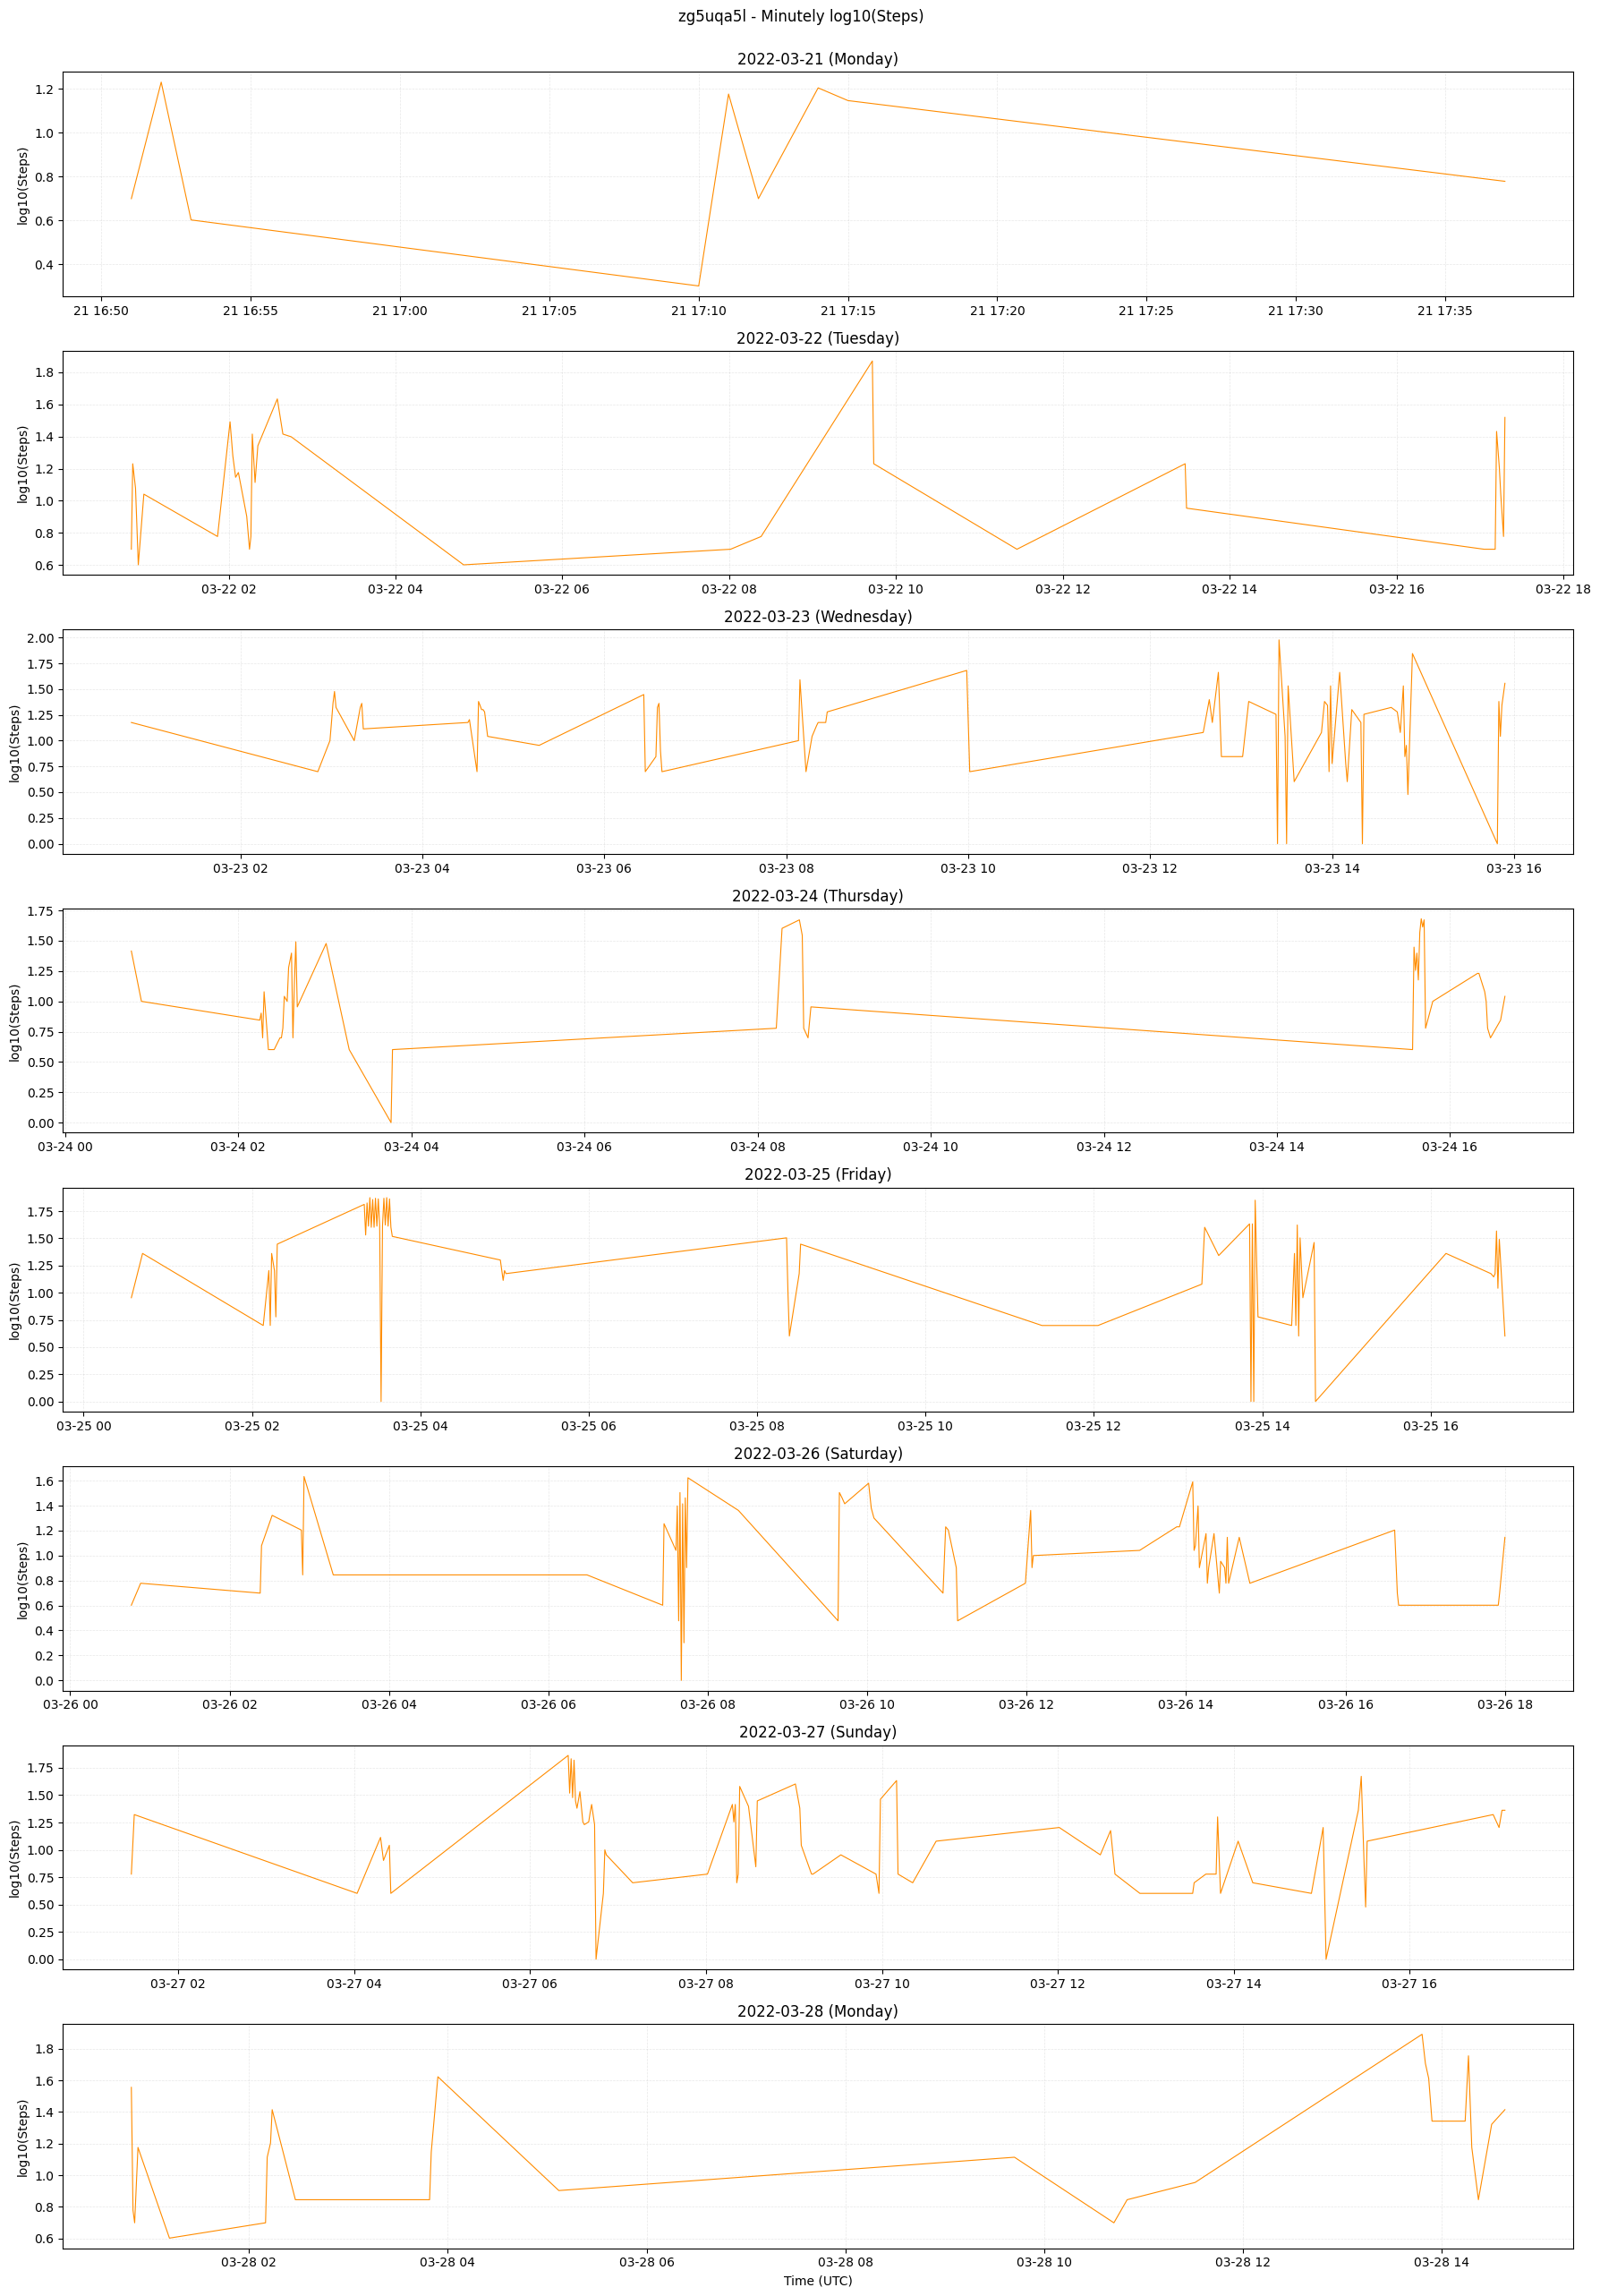

In [ ]:
# Plot log10(minutely step counts) by day for each participant
for subject_id, steps_df in forest_results.items():
    # Filter to positive step values only
    positive_mask = steps_df['steps'] > 0
    if not positive_mask.any():
        print(f'No positive step values for {subject_id}; skipping log plot.')
        continue

    log_df = steps_df.loc[positive_mask].copy()
    log_df['date'] = log_df['timestamp'].dt.date
    log_df['log_steps'] = np.log10(log_df['steps'].clip(lower=1e-6))

    unique_dates = sorted(log_df['date'].unique())
    num_days = len(unique_dates)

    fig, axes = plt.subplots(num_days, 1, figsize=(18, 3.2 * num_days), sharex=False)
    if num_days == 1:
        axes = [axes]

    for ax, day in zip(axes, unique_dates):
        day_df = log_df[log_df['date'] == day]
        times = day_df['timestamp']
        ax.plot(times, day_df['log_steps'], color='darkorange', linewidth=0.8)
        weekday = pd.Timestamp(day).strftime('%A')
        ax.set_title(f'{day} ({weekday})')
        ax.set_ylabel('log10(Steps)')
        ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)

    axes[-1].set_xlabel('Time (UTC)')
    fig.suptitle(f'{subject_id} - Minutely log10(Steps)', y=1.0)
    plt.tight_layout()
    plt.show()


## Compute and Save Hourly Aggregates

Aggregate minutely step data to hourly metrics (walking_time, steps, cadence) and save to CSV.


In [ ]:
# Compute hourly aggregates from minutely data
hourly_results: dict[str, pd.DataFrame] = {}

for subject_id, steps_df in forest_results.items():
    df = steps_df.copy()
    
    # Floor timestamp to hour (use 'h' to avoid deprecation warning)
    df['hour'] = df['timestamp'].dt.floor('h')
    
    # Aggregate by hour
    hourly_df = df.groupby('hour').agg(
        walking_time=('walking_time', 'sum'),  # Total seconds of walking in the hour
        steps=('steps', 'sum'),  # Total steps in the hour
        cadence=('cadence', lambda x: x[x > 0].mean() if (x > 0).any() else np.nan)  # Mean cadence when walking
    ).reset_index()
    
    hourly_df.rename(columns={'hour': 'timestamp'}, inplace=True)
    hourly_results[subject_id] = hourly_df
    
    # Save to CSV
    output_path = Path(OUTPUT_FOLDER) / f'{subject_id}_steps_hourly.csv'
    hourly_df.to_csv(output_path, index=False, date_format='%Y-%m-%dT%H:%M:%S')
    print(f'Saved hourly data for {subject_id}: {len(hourly_df):,} hours -> {output_path}')

print(f'\nComputed hourly aggregates for {len(hourly_results)} participants.')


/tmp/ipykernel_831254/349359082.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['timestamp'].dt.floor('H')
/tmp/ipykernel_831254/349359082.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['timestamp'].dt.floor('H')
/tmp/ipykernel_831254/349359082.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['timestamp'].dt.floor('H')
/tmp/ipykernel_831254/349359082.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['timestamp'].dt.floor('H')
/tmp/ipykernel_831254/349359082.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['timestamp'].dt.floor('H')


Saved hourly data for 3si9xdvl: 192 hours -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/3si9xdvl_steps_hourly.csv
Saved hourly data for bn4j8yj9: 192 hours -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/bn4j8yj9_steps_hourly.csv
Saved hourly data for gq36edfi: 192 hours -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/gq36edfi_steps_hourly.csv
Saved hourly data for ubrmuu2r: 192 hours -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/ubrmuu2r_steps_hourly.csv
Saved hourly data for xwyd72l9: 216 hours -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/xwyd72l9_steps_hourly.csv
Saved hourly data for zg5uqa5l: 192 hours -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/zg5uqa5l_steps_hourly.csv

Computed hourly aggregates for 6 participants.


/tmp/ipykernel_831254/349359082.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['timestamp'].dt.floor('H')


## Compute and Save Daily Aggregates

Aggregate minutely step data to daily metrics (walking_time, steps, cadence) and save to CSV.


In [ ]:
# Compute daily aggregates from minutely data
daily_results: dict[str, pd.DataFrame] = {}

for subject_id, steps_df in forest_results.items():
    df = steps_df.copy()
    
    # Get date from timestamp
    df['date'] = df['timestamp'].dt.date
    
    # Aggregate by day
    daily_df = df.groupby('date').agg(
        walking_time=('walking_time', 'sum'),  # Total seconds of walking in the day
        steps=('steps', 'sum'),  # Total steps in the day
        cadence=('cadence', lambda x: x[x > 0].mean() if (x > 0).any() else np.nan)  # Mean cadence when walking
    ).reset_index()
    
    daily_results[subject_id] = daily_df
    
    # Save to CSV
    output_path = Path(OUTPUT_FOLDER) / f'{subject_id}_steps_daily.csv'
    daily_df.to_csv(output_path, index=False)
    print(f'Saved daily data for {subject_id}: {len(daily_df):,} days -> {output_path}')

print(f'\nComputed daily aggregates for {len(daily_results)} participants.')


Saved daily data for 3si9xdvl: 8 days -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/3si9xdvl_steps_daily.csv
Saved daily data for bn4j8yj9: 8 days -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/bn4j8yj9_steps_daily.csv
Saved daily data for gq36edfi: 8 days -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/gq36edfi_steps_daily.csv
Saved daily data for ubrmuu2r: 8 days -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/ubrmuu2r_steps_daily.csv
Saved daily data for xwyd72l9: 9 days -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/xwyd72l9_steps_daily.csv
Saved daily data for zg5uqa5l: 8 days -> /n/home01/egraff/sample_imputation/data/interim/forest_oak/zg5uqa5l_steps_daily.csv

Computed daily aggregates for 6 participants.


## Daily Summary


In [ ]:
# Display daily summary for each participant
for subject_id, daily_df in daily_results.items():
    print(f'\n=== {subject_id} Daily Summary ===')
    
    # Convert walking_time from seconds to minutes for display
    summary_df = daily_df.copy()
    summary_df['walking_min'] = summary_df['walking_time'] / 60
    summary_df['steps_per_min'] = summary_df['steps'] / summary_df['walking_min']
    
    print(summary_df[['date', 'steps', 'walking_min', 'cadence', 'steps_per_min']].to_string(index=False))
    print(f"\nTotal steps: {daily_df['steps'].sum():,}")
    print(f"Total walking time: {daily_df['walking_time'].sum() / 60:.1f} minutes")



=== 3si9xdvl Daily Summary ===
      date  steps  walking_min  cadence  steps_per_min
2022-03-21 1744.0    16.433333 1.729700     106.125761
2022-03-22  707.0     6.783333 1.698338     104.226044
2022-03-23   19.0     0.183333 1.727273     103.636364
2022-03-24 1606.0    15.350000 1.699661     104.625407
2022-03-25  891.0     8.183333 1.786905     108.879837
2022-03-26 5571.0    52.416667 1.738281     106.282989
2022-03-27  172.0     1.766667 1.628404      97.358491
2022-03-28    0.0     0.000000      NaN            NaN

Total steps: 10,710.0
Total walking time: 101.1 minutes

=== bn4j8yj9 Daily Summary ===
      date  steps  walking_min  cadence  steps_per_min
2022-03-21 1251.0    10.100000 1.898190     123.861386
2022-03-22  512.0     4.783333 1.732719     107.038328
2022-03-23 2405.0    19.383333 1.989941     124.075666
2022-03-24 2826.0    23.316667 1.913274     121.200858
2022-03-25  503.0     4.533333 1.782453     110.955882
2022-03-26  737.0     6.700000 1.769609     110.000000

In [ ]:
## Cadence Distribution Analysis


NameError: name 'subject_steps' is not defined

In [ ]:
# Combine all subjects for cadence analysis (forest-derived steps)
all_cadence = []
for subject_id, steps_df in forest_results.items():
    valid_cadence = steps_df.loc[steps_df['cadence'] > 0, 'cadence'].values
    all_cadence.extend(valid_cadence)

if all_cadence:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram in Hz
    axes[0].hist(all_cadence, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
    axes[0].axvline(x=1.4, color='red', linestyle='--', label='Min step freq (1.4 Hz)')
    axes[0].axvline(x=2.3, color='red', linestyle='--', label='Max step freq (2.3 Hz)')
    axes[0].set_xlabel('Cadence (Hz)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Cadence Distribution (Hz)')
    axes[0].legend()
    
    # Histogram in steps/min
    cadence_spm = [c * 60 for c in all_cadence]
    axes[1].hist(cadence_spm, bins=50, color='forestgreen', edgecolor='white', alpha=0.8)
    axes[1].axvline(x=84, color='red', linestyle='--', label='Min (84 steps/min)')
    axes[1].axvline(x=138, color='red', linestyle='--', label='Max (138 steps/min)')
    axes[1].set_xlabel('Cadence (steps/min)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Cadence Distribution (steps/min)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f'Mean cadence: {np.mean(all_cadence):.2f} Hz ({np.mean(all_cadence)*60:.1f} steps/min)')
    print(f'Median cadence: {np.median(all_cadence):.2f} Hz ({np.median(all_cadence)*60:.1f} steps/min)')
else:
    print('No walking detected across all subjects.')


NameError: name 'forest_results' is not defined

## Output Files Summary

This notebook generated the following files in `data/interim/forest_oak/`:

**Minutely data** (from forest oak):
- `minute/{participant_id}_gait_hourly.csv` - Minutely step counts

**Hourly aggregates**:
- `{participant_id}_steps_hourly.csv` - Columns: timestamp, walking_time (seconds), steps, cadence (Hz)

**Daily aggregates**:
- `{participant_id}_steps_daily.csv` - Columns: date, walking_time (seconds), steps, cadence (Hz)

For comparison with the ported version, see `05b_compare_forest_steps.ipynb`.
